## **4. Methodology**

### **4.1 Overview of Experimental Procedure**

This study conducts a comparative evaluation of three fine-tuned versions of the DeiT-Small Vision Transformer (ViT) architecture on a custom image classification task. The complete process involves dataset preparation, model setup, training with carefully controlled variations, and performance evaluation using consistent metrics across versions.

---

### **4.2 Dataset Preparation**

A custom image dataset consisting of 700 original images across 7 distinct classes was augmented to a total of approximately 4900 images. Each image filename was prefixed with a base identifier to retain a link between original images and their augmented variants.

To ensure a fair evaluation and avoid data leakage, group-wise splitting was applied. Images sharing a common base identifier were grouped together, and these groups were then randomly divided into three disjoint subsets:
- **Training Set**: 70%
- **Validation Set**: 15%
- **Test Set**: 15%

This ensured that no augmented image derived from a particular original image appeared in multiple splits. Transformations applied during data loading included resizing to 224×224 pixels and normalization with ImageNet statistics to meet DeiT-Small input requirements.

---

### **4.3 Model Architecture and Training Configurations**

Three versions of the DeiT-Small (`deit_small_patch16_224`) model were fine-tuned using different strategies. All models were built using the `timm` library and trained using PyTorch.

#### **4.3.1 Version 1 (V1)**
- **Pretrained Weights**: Yes (ImageNet)
- **Frozen Layers**: Patch embedding + first four transformer blocks
- **Classifier Head**: Standard linear head replaced with custom head (512 units + ReLU + Linear)
- **Optimizer**: AdamW with a learning rate of 1e-4
- **Scheduler**: StepLR (gamma=0.1 every 5 epochs)
- **Early Stopping**: Patience of 3 epochs
- **Dropout**: Not used in this version

#### **4.3.2 Version 2 (V2)**
- **Pretrained Weights**: Custom weights from V1 (excluding classifier head)
- **Frozen Layers**: Patch embedding + first three transformer blocks
- **Classifier Head**: Sequential head (512 units + ReLU + Dropout 0.5 + LayerNorm + Linear)
- **Optimizer**: AdamW with layer-wise learning rates
- **Scheduler**: CosineAnnealingLR
- **Early Stopping**: Patience of 6 epochs

#### **4.3.3 Version 3 (V3)**
- **Pretrained Weights**: Custom weights from V2 (excluding classifier head)
- **Frozen Layers**: Initially patch embedding + first three transformer blocks
- **Classifier Head**: Same structure as V2, with dropout adjusted to 0.5
- **Training Strategy**: Gradual unfreezing of transformer blocks at epochs 4, 7, and 10
- **Optimizer**: AdamW with layer-wise learning rates
- **Scheduler**: ReduceLROnPlateau (based on validation loss)
- **Early Stopping**: Patience of 6 epochs
- **Additional Monitoring**: Gradient statistics collected for trainable layers

---

### **4.4 Evaluation Protocol**

All models were evaluated using the same test split to ensure fair comparison. Evaluation metrics included:
- **Accuracy**
- **Precision, Recall, F1-score (per class and averaged)**
- **Specificity**
- **Matthews Correlation Coefficient (MCC)**
- **Cohen’s Kappa**
- **Top-k Accuracy (k = 1, 3, 5)**
- **ROC AUC and Precision-Recall Curves**
- **Gradient Magnitude Analysis (V3 only)**

Evaluation outputs were saved in structured directories for each version. Confusion matrices, ROC curves, and precision-recall curves were visualized for interpretability. In addition, training histories (loss and accuracy curves) were plotted and analyzed for convergence behavior and overfitting trends.

---

### **4.5 Model Saving and Artifact Organization**

Each version of the model was saved along with its training history, evaluation metrics, and diagnostic visualizations. Artifacts were organized into version-specific directories (`V1_Results`, `V2_Results`, `V3_Results`). Final test evaluations were saved separately under `Test_Eval` subdirectories.

# Import necessary libraries

In [16]:
# Required libraries are imported.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
from tqdm import tqdm
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

In [76]:
import sys
# the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from Utils.utils import evaluate_model, plotting, save_deit_artifacts

In [17]:
# The dataset path is defined.
dataset_path = "/Users/tahfimibnkhan/Desktop/ViT/DATASET/AUGMENTED_DATASET"

# Transformations are applied to the images.
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 256x256
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

In [18]:
# The dataset is loaded using ImageFolder.
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# The number of classes in the dataset is obtained.
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 7


In [19]:
import os
import random
from torchvision import datasets
from torch.utils.data import DataLoader, Subset

# Groups of images were prepared using base image identifiers
image_groups = {}
for img_path, _ in dataset.samples:
    filename = os.path.basename(img_path)
    original_id = "_".join(filename.split("_")[:-1])  # Base ID was extracted before augmentation tags
    if original_id not in image_groups:
        image_groups[original_id] = []
    image_groups[original_id].append(img_path)

# Group keys were shuffled to ensure random distribution
random.seed(42)
group_keys = list(image_groups.keys())
random.shuffle(group_keys)

# The dataset was split into training (70%), validation (15%), and test (15%) sets
total = len(group_keys)
train_size = round(0.70 * total)
val_size = round(0.15 * total)
test_size = total - train_size - val_size

train_keys = set(group_keys[:train_size])
val_keys = set(group_keys[train_size:train_size + val_size])
test_keys = set(group_keys[train_size + val_size:])

# Indices were assigned to the appropriate split based on the group identifier
train_indices, val_indices, test_indices = [], [], []

for idx, (img_path, _) in enumerate(dataset.samples):
    filename = os.path.basename(img_path)
    original_id = "_".join(filename.split("_")[:-1])
    if original_id in train_keys:
        train_indices.append(idx)
    elif original_id in val_keys:
        val_indices.append(idx)
    elif original_id in test_keys:
        test_indices.append(idx)

# Subsets were created for each split
train_data = Subset(dataset, train_indices)
val_data = Subset(dataset, val_indices)
test_data = Subset(dataset, test_indices)

# Data loaders were initialized for model1training and evaluation
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

Training samples: 3462
Validation samples: 709
Test samples: 729


In [20]:
num_classes = 7  # The number of target classes is specified for classification.

# The DeiT-Small model1is loaded with pre-trained weights, and the classification head is adjusted.
model1 = timm.create_model('deit_small_patch16_224', pretrained=True, num_classes=num_classes)

# The patch embedding layer is frozen to retain pre-trained features.
for param in model1.patch_embed.parameters():
    param.requires_grad = False  

# The first four transformer blocks are frozen to preserve learned representations.
for i in range(4):  
    for param in model1.blocks[i].parameters():
        param.requires_grad = False  

# The model1is transferred to GPU if available; otherwise, it remains on CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)

print(f"Model1 loaded, early layers frozen, and moved to {device}")

Model1 loaded, early layers frozen, and moved to cpu


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# The loss function is defined using CrossEntropyLoss for multi-class classification.
criterion = nn.CrossEntropyLoss()

# The optimizer is defined using AdamW, which is preferred over Adam due to better weight decay handling.
optimizer = optim.AdamW(model1.parameters(), lr=1e-4, weight_decay=1e-5)

# A step-based learning rate scheduler is used, reducing the learning rate by a factor of 0.1 every 5 epochs.
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print("Loss function, optimizer, and learning rate scheduler have been defined.")

Loss function, optimizer, and learning rate scheduler have been defined.


In [22]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=15):
    history1 = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    # Early stopping initialization
    best_val_loss = float('inf')
    patience = 3
    epochs_no_improve = 0

    for epoch in range(epochs):
        # Training Phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        history1["train_loss"].append(train_loss)
        history1["train_acc"].append(train_acc)

        # Validation Phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        history1["val_loss"].append(val_loss)
        history1["val_acc"].append(val_acc)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"\nEarly stopping triggered at epoch {epoch+1}!")
                break

        # Adjust learning rate
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return history1
# Training and getting history
history1= train(model1, train_loader, val_loader, criterion, optimizer, scheduler, epochs=15)

Epoch 1/15: 100%|█████████████████████████████| 109/109 [05:24<00:00,  2.98s/it]


Epoch 1/15: Train Loss: 0.6073, Train Acc: 77.99% | Val Loss: 0.2715, Val Acc: 90.69%


Epoch 2/15: 100%|█████████████████████████████| 109/109 [05:12<00:00,  2.87s/it]


Epoch 2/15: Train Loss: 0.1453, Train Acc: 95.00% | Val Loss: 0.1966, Val Acc: 93.51%


Epoch 3/15: 100%|█████████████████████████████| 109/109 [05:26<00:00,  2.99s/it]


Epoch 3/15: Train Loss: 0.0533, Train Acc: 98.30% | Val Loss: 0.3133, Val Acc: 89.70%


Epoch 4/15: 100%|█████████████████████████████| 109/109 [05:28<00:00,  3.02s/it]


Epoch 4/15: Train Loss: 0.0475, Train Acc: 98.47% | Val Loss: 0.1754, Val Acc: 94.36%


Epoch 5/15: 100%|█████████████████████████████| 109/109 [05:42<00:00,  3.15s/it]


Epoch 5/15: Train Loss: 0.0232, Train Acc: 99.34% | Val Loss: 0.1838, Val Acc: 94.08%


Epoch 6/15: 100%|█████████████████████████████| 109/109 [05:51<00:00,  3.22s/it]


Epoch 6/15: Train Loss: 0.0035, Train Acc: 100.00% | Val Loss: 0.1258, Val Acc: 95.91%


Epoch 7/15: 100%|█████████████████████████████| 109/109 [06:28<00:00,  3.56s/it]


Epoch 7/15: Train Loss: 0.0023, Train Acc: 100.00% | Val Loss: 0.1222, Val Acc: 95.91%


Epoch 8/15: 100%|█████████████████████████████| 109/109 [07:03<00:00,  3.88s/it]


Epoch 8/15: Train Loss: 0.0021, Train Acc: 100.00% | Val Loss: 0.1208, Val Acc: 96.05%


Epoch 9/15: 100%|█████████████████████████████| 109/109 [07:44<00:00,  4.26s/it]


Epoch 9/15: Train Loss: 0.0019, Train Acc: 100.00% | Val Loss: 0.1197, Val Acc: 96.05%


Epoch 10/15: 100%|████████████████████████████| 109/109 [07:25<00:00,  4.08s/it]


Epoch 10/15: Train Loss: 0.0018, Train Acc: 100.00% | Val Loss: 0.1187, Val Acc: 96.19%


Epoch 11/15: 100%|████████████████████████████| 109/109 [05:52<00:00,  3.23s/it]


Epoch 11/15: Train Loss: 0.0017, Train Acc: 100.00% | Val Loss: 0.1186, Val Acc: 96.19%


Epoch 12/15: 100%|████████████████████████████| 109/109 [05:26<00:00,  2.99s/it]


Epoch 12/15: Train Loss: 0.0017, Train Acc: 100.00% | Val Loss: 0.1186, Val Acc: 96.19%


Epoch 13/15: 100%|████████████████████████████| 109/109 [05:20<00:00,  2.94s/it]


Epoch 13/15: Train Loss: 0.0017, Train Acc: 100.00% | Val Loss: 0.1185, Val Acc: 96.19%


Epoch 14/15: 100%|████████████████████████████| 109/109 [05:32<00:00,  3.05s/it]


Epoch 14/15: Train Loss: 0.0016, Train Acc: 100.00% | Val Loss: 0.1184, Val Acc: 96.19%


Epoch 15/15: 100%|████████████████████████████| 109/109 [05:46<00:00,  3.17s/it]


Epoch 15/15: Train Loss: 0.0016, Train Acc: 100.00% | Val Loss: 0.1184, Val Acc: 96.19%


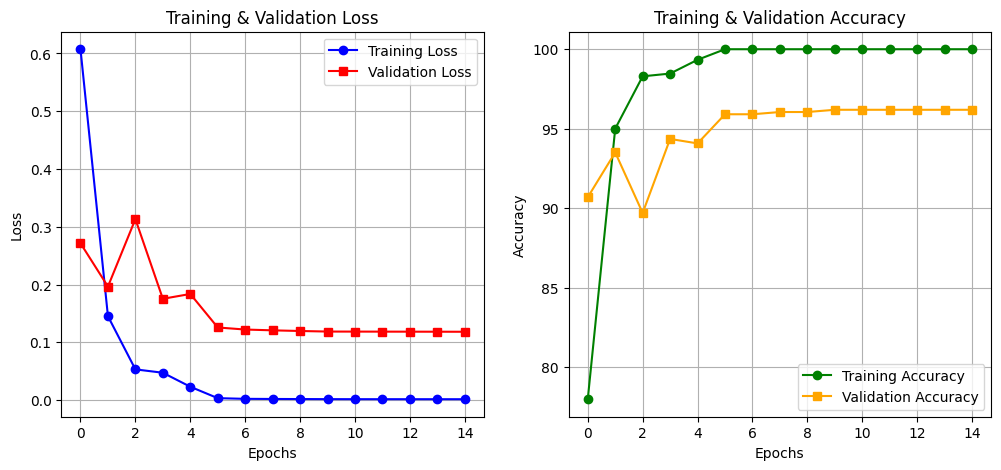

In [77]:
plottting1=plotting(history1)

# Computeing Performance Metrics


Evaluating model with Validation loader...

Overall Accuracy: 96.19%
Overall Error Rate: 3.81%
F1-Score (Macro-Averaged): 96.17%
F1-Score (Weighted): 96.19%
Matthews Correlation Coefficient (MCC): 95.56%
Cohen’s Kappa Score: 95.55%
Top-1 Accuracy (%): 96.19%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.030922 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          93.81       95.50         94.64            98.83
 BRRI_28          98.80       91.11         94.80            99.84
 BRRI_29          92.92       94.59         93.75            98.66
 BRRI_34          97.22       98.13         97.67            99.50
 BRRI_50          94.12       97.56         95.81            99.20
 BRRI_74          99.07      100.00         99.53            99.83
    BR_5          97.98       96.04         97.00            99.67

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                111
 B

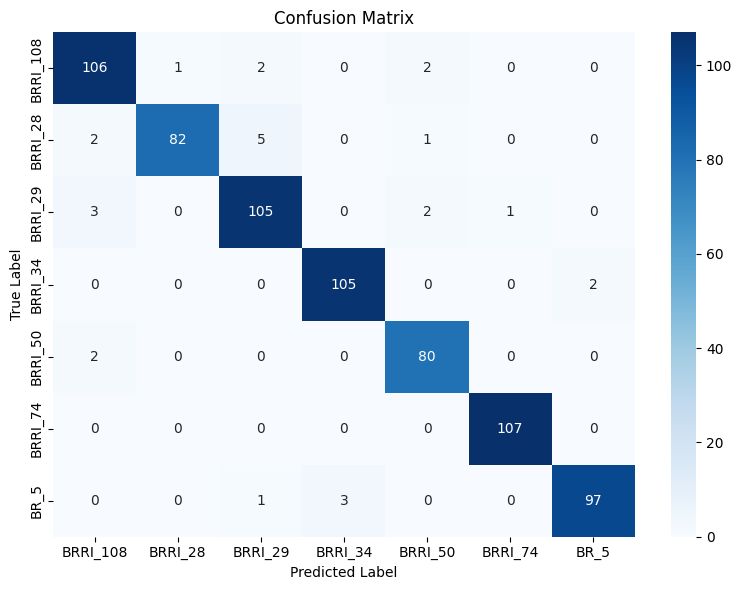

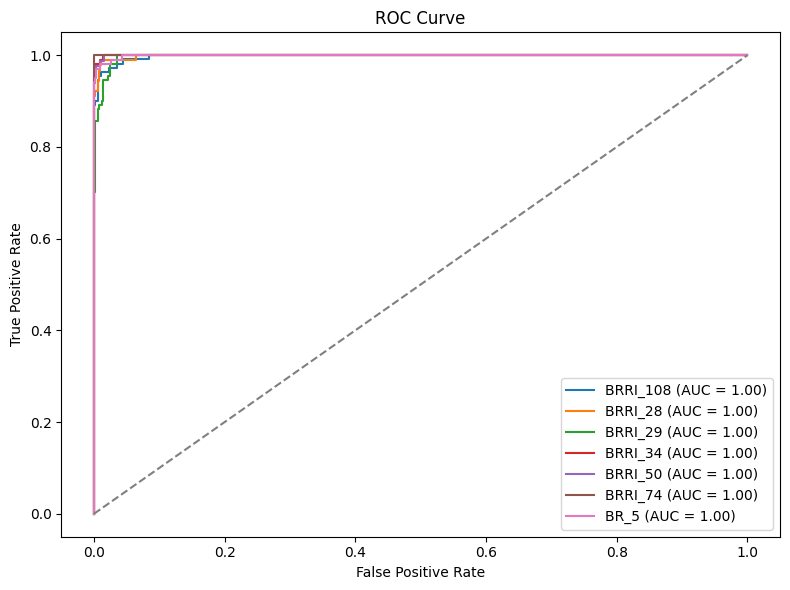

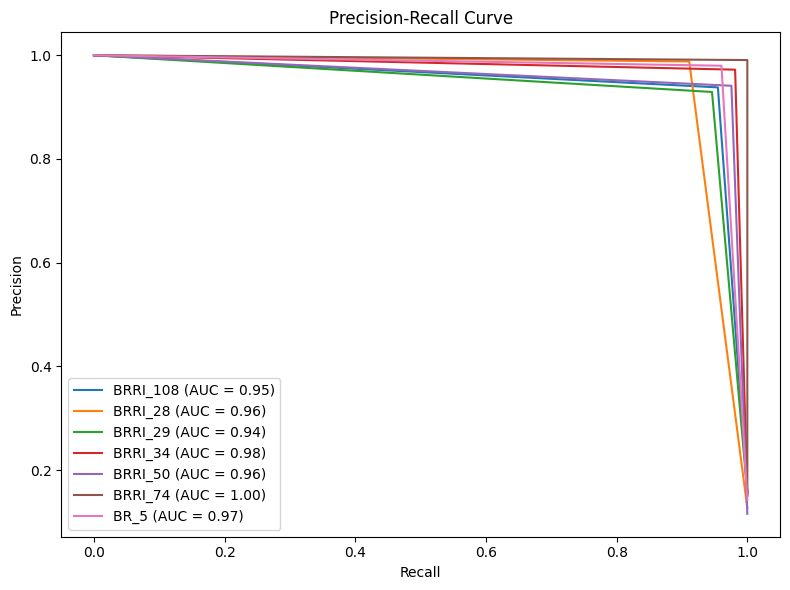

In [85]:
metrics1=evaluate_model(model1, val_loader, class_names=dataset.classes, loader_name="Validation")


Evaluating model with Testing loader...

Overall Accuracy: 96.02%
Overall Error Rate: 3.98%
F1-Score (Macro-Averaged): 96.07%
F1-Score (Weighted): 96.02%
Matthews Correlation Coefficient (MCC): 95.36%
Cohen’s Kappa Score: 95.35%
Top-1 Accuracy (%): 96.02%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.033560 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          94.64       90.60         92.58            99.02
 BRRI_28          96.61       95.00         95.80            99.34
 BRRI_29          90.72       95.65         93.12            98.59
 BRRI_34          95.61      100.00         97.76            99.19
 BRRI_50          97.25       98.15         97.70            99.52
 BRRI_74          97.83       98.90         98.36            99.69
    BR_5         100.00       94.57         97.21           100.00

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                117
 BRRI

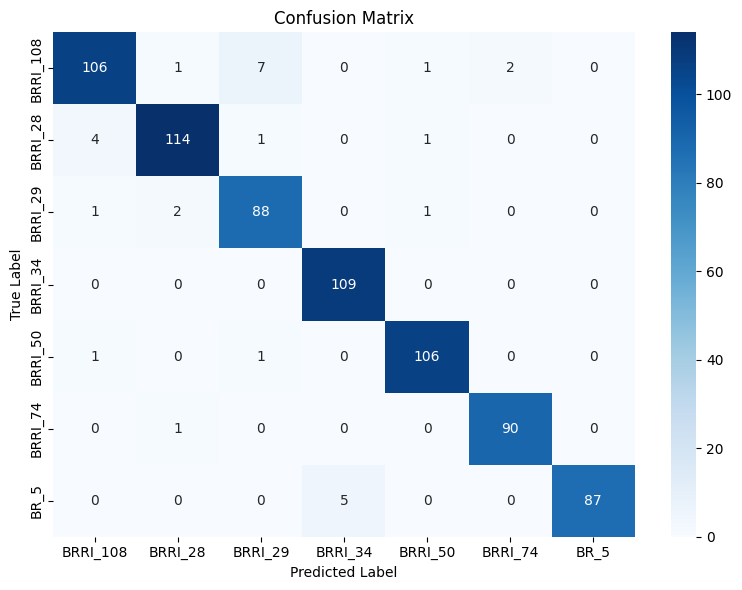

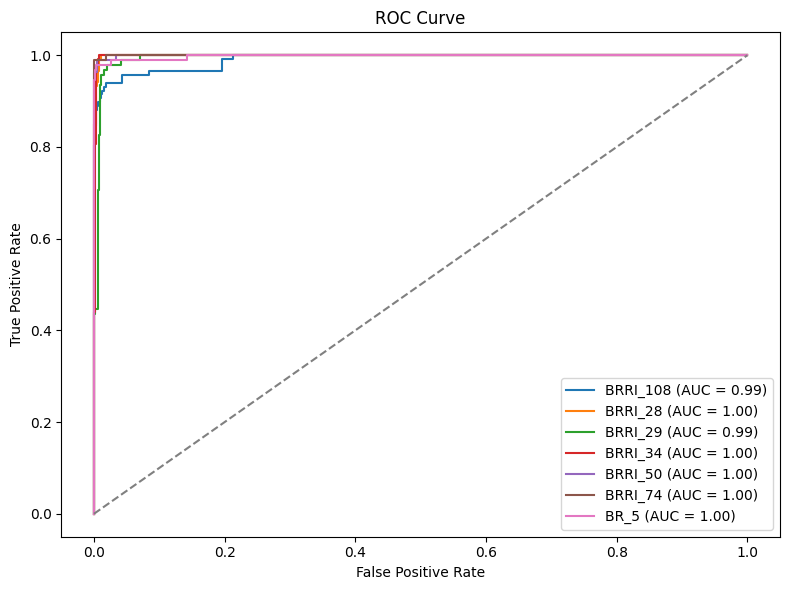

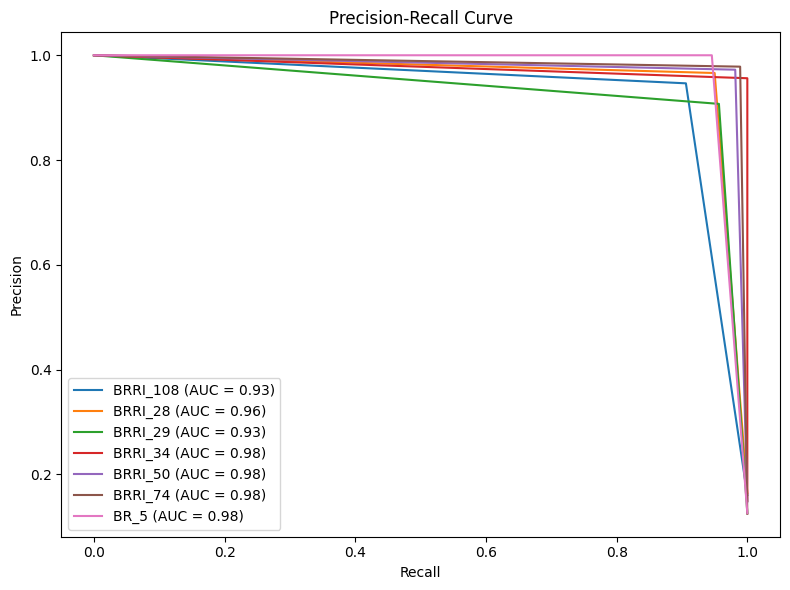

In [86]:
metrics1=evaluate_model(model1, test_loader, class_names=dataset.classes, loader_name="Testing")

In [87]:
def save_deit_artifacts(model, history, metrics, version="V1", base_dir="/Users/tahfimibnkhan/Desktop/ViT_Final"):
    logs_dir = os.path.join(base_dir, "RESULTS", "logs")
    os.makedirs(logs_dir, exist_ok=True)

    training_metrics = {
        "train_loss": history["train_loss"][-1],
        "train_acc": history["train_acc"][-1],
        "val_loss": history["val_loss"][-1],
        "val_acc": history["val_acc"][-1]
    }

    training_metrics_path = os.path.join(logs_dir, f"deit_small_training_metrics_{version}.json")
    with open(training_metrics_path, "w") as f:
        json.dump(training_metrics, f, indent=4)
    print(f"Training metrics logged to {training_metrics_path}")

    model_dir = os.path.join(base_dir, "MODELS", "deit_small")
    os.makedirs(model_dir, exist_ok=True)
    model.to("cpu")
    model_path = os.path.join(model_dir, f"deit_small_{version}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    eval_dir = os.path.join(base_dir, "RESULTS", "evaluation_logs")
    os.makedirs(eval_dir, exist_ok=True)

    eval_metrics_path = os.path.join(eval_dir, f"deit_evaluation_metrics_{version}.json")
    with open(eval_metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)
    print(f"Evaluation metrics saved at: {eval_metrics_path}")

    class_metrics = metrics.get("Class-Wise Metrics") or metrics.get("class_metrics")
    if class_metrics:
        class_metrics_df = pd.DataFrame(class_metrics)
        class_metrics_path = os.path.join(eval_dir, f"deit_class_wise_metrics_{version}.csv")
        class_metrics_df.to_csv(class_metrics_path, index=False)
        print(f"Class-wise metrics saved at: {class_metrics_path}")
    else:
        print("No class-wise metrics found in evaluation results.")
        
save_deit_artifacts(model1, history1, metrics1, version="1")

Training metrics logged to /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/logs/deit_small_training_metrics_1.json
Model saved to /Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/deit_small/deit_small_1.pth
Evaluation metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/deit_evaluation_metrics_1.json
Class-wise metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/deit_class_wise_metrics_1.csv


In [156]:
import os
import json

def save_history(history, version="V1", base_dir="/Users/tahfimibnkhan/Desktop/ViT_Final"):
    """
    Saves the full training history to a JSON file.

    Args:
        history (dict): Dictionary containing lists of training/validation metrics.
        version (str): Version label (e.g., 'V1', '1', 'deit_3').
        base_dir (str): Root directory for saving results.
    """
    logs_dir = os.path.join(base_dir, "RESULTS", "logs")
    os.makedirs(logs_dir, exist_ok=True)

    file_path = os.path.join(logs_dir, f"deit_small_full_history_{version}.json")

    with open(file_path, "w") as f:
        json.dump(history, f, indent=4)

    print(f"History saved to {file_path}")
save_history(history1, version="1")

History saved to /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/logs/deit_small_full_history_1.json


# Version 2

In [111]:
import timm
import torch
import torch.nn as nn
import sys
# the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from Utils.utils import evaluate_model, plotting, save_deit_artifacts

# The device is automatically selected based on availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The DeiT-Small architecture is initialized without pretrained weights
model2 = timm.create_model("deit_small_patch16_224", pretrained=False, num_classes=num_classes)

# Custom pretrained weights are loaded from the specified path
model_path = "/Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/deit_small/deit_small_1.pth"
model2.load_state_dict(torch.load(model_path, map_location=device))

# The classification head is replaced with a custom sequential module
in_features = model2.head.in_features
model2.head = nn.Sequential(
    nn.Linear(in_features, 512),  # An intermediate linear layer is added
    nn.ReLU(),  # Non-linearity is introduced
    nn.Dropout(p=0.6),  # Regularization is applied through dropout
    nn.LayerNorm(512),  # Normalization is included for stability
    nn.Linear(512, num_classes)  # Final classification is performed
)

# The patch embedding layer is kept frozen
for param in model2.patch_embed.parameters():  
    param.requires_grad = False  

# The first three transformer blocks are maintained in frozen state
for i in range(3):
    for param in model2.blocks[i].parameters():
        param.requires_grad = False

# The model is transferred to the available computing device
model2.to(device)

# Model configuration is confirmed through console output
print(f"Model2 is prepared for fine-tuning with {sum(p.requires_grad for p in model2.parameters())} trainable parameters on {device}")

Model2 is prepared for fine-tuning with 118 trainable parameters on cpu


In [112]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# Defined loss function
criterion = nn.CrossEntropyLoss()

# Optimizer with layer-wise learning rate decay (recommended for ViTs)
optimizer = optim.AdamW([
    {'params': model2.patch_embed.parameters(), 'lr': 1e-5},
    {'params': model2.blocks.parameters(), 'lr': 3e-5},
    {'params': model2.head.parameters(), 'lr': 5e-5}
], weight_decay=5e-5)

# Learning rate scheduler (chose Cosine Annealing for smooth decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)  

print("Loss function, optimizer, and learning rate scheduler have been defined.")

Loss function, optimizer, and learning rate scheduler have been defined.


In [105]:
def train_model2(model2, train_loader, val_loader, criterion, optimizer, scheduler, epochs, patience):
    """
    The model is trained with early stopping and learning rate scheduling.
    Training progress and metrics are tracked and returned.
    """
    # Training history is initialized for metric tracking
    history2 = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    # Early stopping parameters are configured
    best_val_loss = float("inf")
    early_stop_counter = 0  

    for epoch in range(epochs):
        # The model is set to training mode
        model2.train()
        running_loss, correct_predictions, total_samples = 0.0, 0, 0

        # Training batches are processed
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            # Forward and backward passes are executed
            optimizer.zero_grad()
            outputs = model2(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Metrics are accumulated
            running_loss += loss.item()
            predicted_labels = torch.argmax(outputs, dim=1)
            total_samples += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum().item()

        # Training metrics are calculated and stored
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100. * correct_predictions / total_samples
        history2["train_loss"].append(epoch_train_loss)
        history2["train_acc"].append(epoch_train_acc)

        # Validation phase is initiated
        model2.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        # Validation batches are processed without gradient computation
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model2(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Validation metrics are calculated and stored
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100. * val_correct / val_total
        history2["val_loss"].append(epoch_val_loss)
        history2["val_acc"].append(epoch_val_acc)

        # Progress is reported
        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | "
              f"Train Acc: {epoch_train_acc:.2f}% | Val Acc: {epoch_val_acc:.2f}%")

        # Model improvement is checked
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            early_stop_counter = 0
            torch.save(model2.state_dict(), "deit_smallV2_best.pth")
            print("Validation loss improved - model weights saved.")
        else:
            early_stop_counter += 1
            print(f"No improvement counter: {early_stop_counter}/{patience}")
            if early_stop_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

        # Learning rate is adjusted according to scheduler type
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(epoch_val_loss)
        else:
            scheduler.step()

    return history2

# This one is extra, tried to train with 60% dropout. But it stopped early. So This one is discarted. But keeping it for future referencing.

In [98]:
# The model is trained with configured parameters
history2 = train_model2(
    model2=model2,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=15,
    patience=8
)

Epoch 1/15: 100%|█████████████████████████████| 109/109 [08:48<00:00,  4.85s/it]


Epoch 1/15: Train Loss: 0.2923 | Val Loss: 0.3184 | Train Acc: 95.58% | Val Acc: 91.96%
Validation loss improved - model weights saved.


Epoch 2/15: 100%|█████████████████████████████| 109/109 [08:25<00:00,  4.63s/it]


Epoch 2/15: Train Loss: 0.0426 | Val Loss: 0.1088 | Train Acc: 99.83% | Val Acc: 97.04%
Validation loss improved - model weights saved.


Epoch 3/15: 100%|█████████████████████████████| 109/109 [08:21<00:00,  4.60s/it]


Epoch 3/15: Train Loss: 0.0218 | Val Loss: 0.1330 | Train Acc: 100.00% | Val Acc: 96.90%
No improvement counter: 1/8


Epoch 4/15: 100%|█████████████████████████████| 109/109 [08:19<00:00,  4.58s/it]


Epoch 4/15: Train Loss: 0.0156 | Val Loss: 0.1309 | Train Acc: 100.00% | Val Acc: 97.18%
No improvement counter: 2/8


Epoch 5/15: 100%|█████████████████████████████| 109/109 [08:39<00:00,  4.77s/it]


Epoch 5/15: Train Loss: 0.0122 | Val Loss: 0.1378 | Train Acc: 100.00% | Val Acc: 97.32%
No improvement counter: 3/8


Epoch 6/15: 100%|█████████████████████████████| 109/109 [09:28<00:00,  5.22s/it]


Epoch 6/15: Train Loss: 0.0102 | Val Loss: 0.1424 | Train Acc: 100.00% | Val Acc: 97.32%
No improvement counter: 4/8


Epoch 7/15: 100%|█████████████████████████████| 109/109 [08:27<00:00,  4.65s/it]


Epoch 7/15: Train Loss: 0.0089 | Val Loss: 0.1466 | Train Acc: 100.00% | Val Acc: 97.18%
No improvement counter: 5/8


Epoch 8/15: 100%|█████████████████████████████| 109/109 [08:15<00:00,  4.55s/it]


Epoch 8/15: Train Loss: 0.0079 | Val Loss: 0.1468 | Train Acc: 100.00% | Val Acc: 97.18%
No improvement counter: 6/8


Epoch 9/15: 100%|█████████████████████████████| 109/109 [08:18<00:00,  4.57s/it]


Epoch 9/15: Train Loss: 0.0071 | Val Loss: 0.1500 | Train Acc: 100.00% | Val Acc: 97.18%
No improvement counter: 7/8


Epoch 10/15: 100%|████████████████████████████| 109/109 [08:17<00:00,  4.57s/it]


Epoch 10/15: Train Loss: 0.0066 | Val Loss: 0.1543 | Train Acc: 100.00% | Val Acc: 97.32%
No improvement counter: 8/8
Early stopping triggered after 10 epochs.


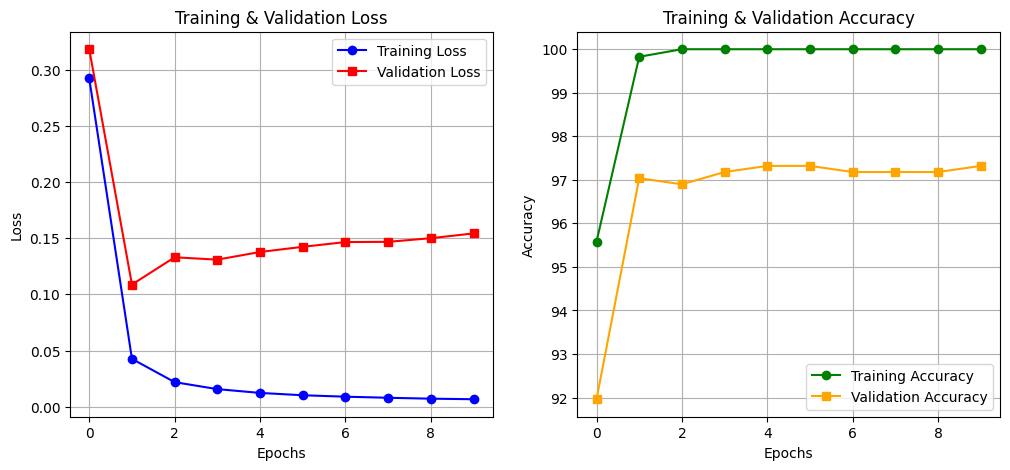

In [99]:
plottting2=plotting(history2)


Evaluating model with Validation loader...

Overall Accuracy: 97.32%
Overall Error Rate: 2.68%
F1-Score (Macro-Averaged): 97.34%
F1-Score (Weighted): 97.32%
Matthews Correlation Coefficient (MCC): 96.87%
Cohen’s Kappa Score: 96.87%
Top-1 Accuracy (%): 97.32%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.028380 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          96.43       97.30         96.86            99.33
 BRRI_28          98.85       95.56         97.18            99.84
 BRRI_29          95.45       94.59         95.02            99.16
 BRRI_34          98.11       97.20         97.65            99.67
 BRRI_50          95.35      100.00         97.62            99.36
 BRRI_74         100.00      100.00        100.00           100.00
    BR_5          97.03       97.03         97.03            99.51

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                111
 B

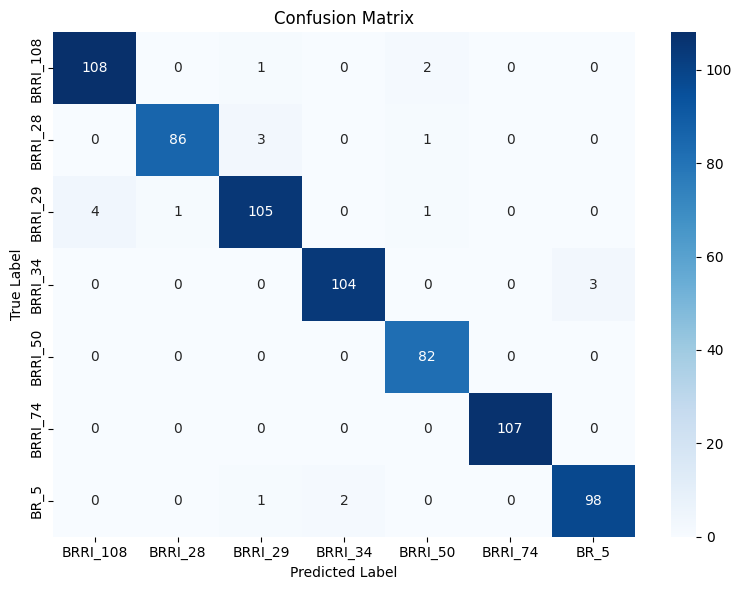

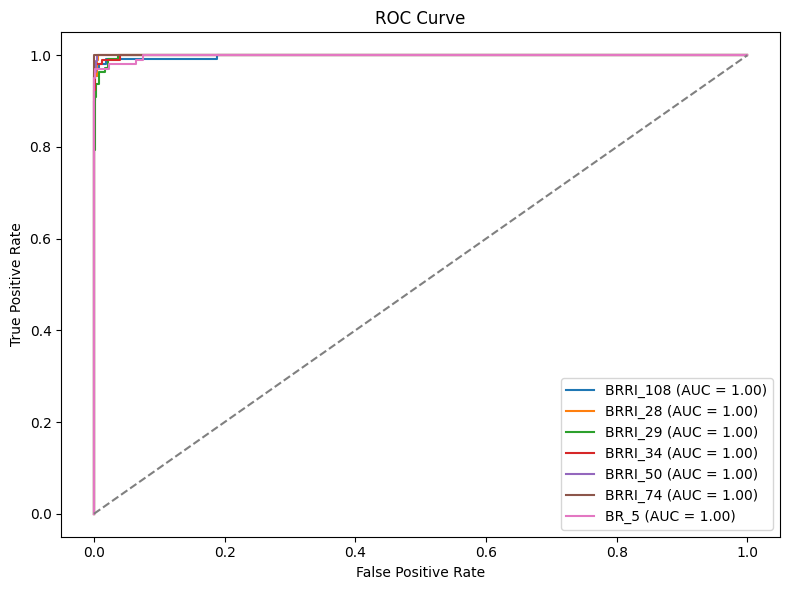

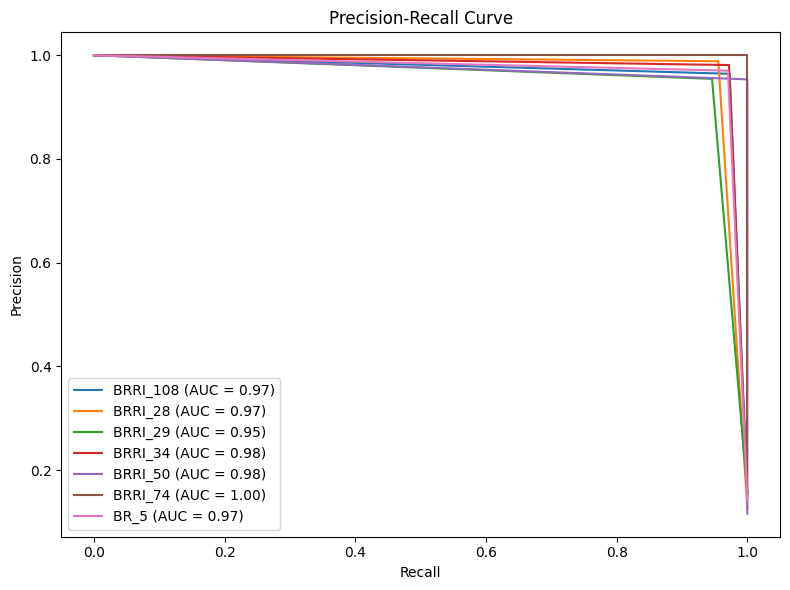

In [100]:
metrics2=evaluate_model(model2, val_loader, class_names=dataset.classes, loader_name="Validation")


Evaluating model with Testing loader...

Overall Accuracy: 97.12%
Overall Error Rate: 2.88%
F1-Score (Macro-Averaged): 97.15%
F1-Score (Weighted): 97.12%
Matthews Correlation Coefficient (MCC): 96.64%
Cohen’s Kappa Score: 96.63%
Top-1 Accuracy (%): 97.12%
Top-5 Accuracy (%): 99.86%

Average Inference Time per Image: 0.025736 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          96.43       92.31         94.32            99.35
 BRRI_28          97.52       98.33         97.93            99.51
 BRRI_29          92.71       96.74         94.68            98.90
 BRRI_34          97.32      100.00         98.64            99.52
 BRRI_50          97.22       97.22         97.22            99.52
 BRRI_74          98.90       98.90         98.90            99.84
    BR_5         100.00       96.74         98.34           100.00

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                117
 BRRI_

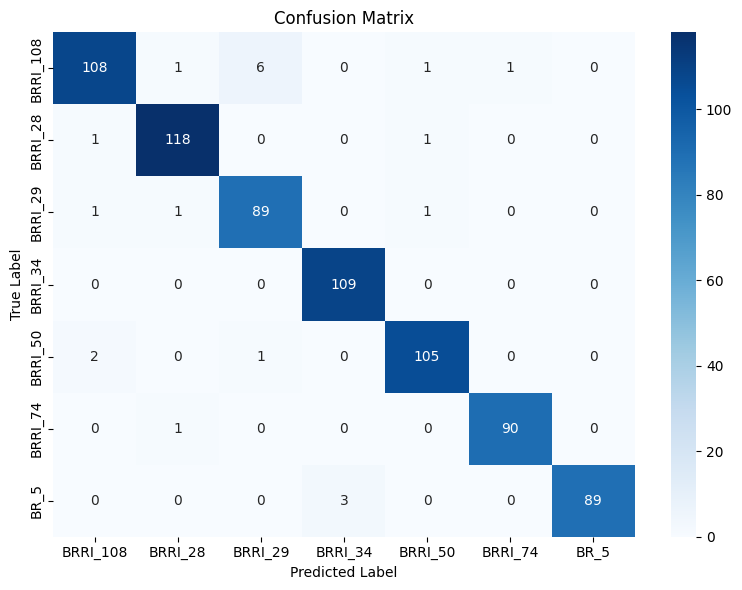

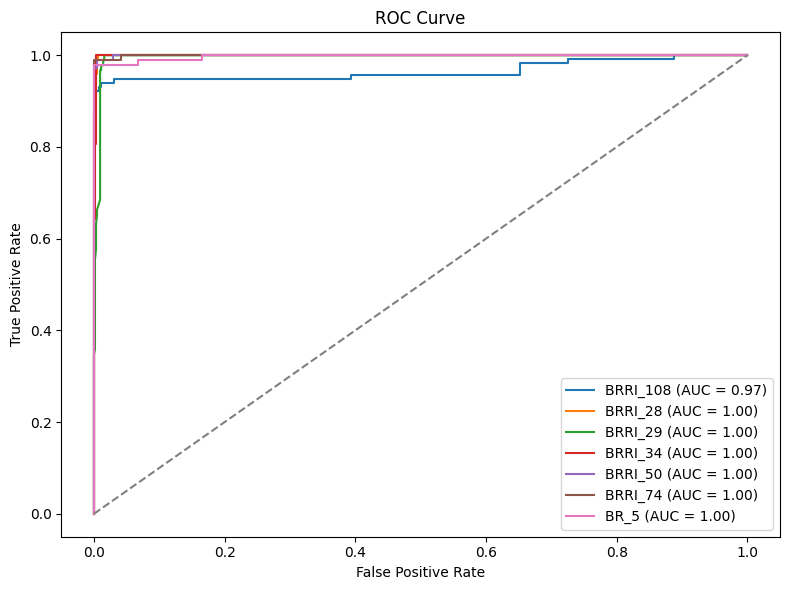

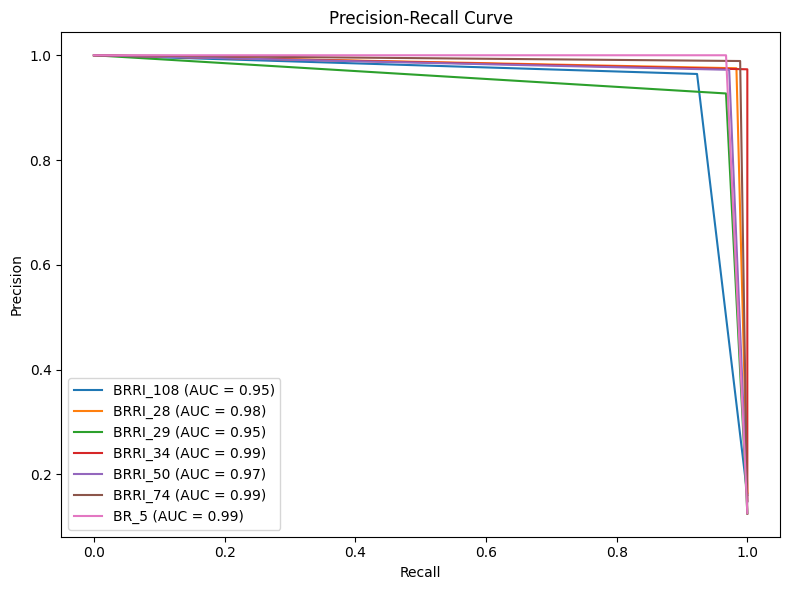

In [102]:
metrics2=evaluate_model(model2, test_loader, class_names=dataset.classes, loader_name="Testing")

In [107]:
def save_deit_artifacts(model, history, metrics, version="V1", base_dir="/Users/tahfimibnkhan/Desktop/ViT_Final"):
    logs_dir = os.path.join(base_dir, "RESULTS", "logs")
    os.makedirs(logs_dir, exist_ok=True)

    training_metrics = {
        "train_loss": history["train_loss"][-1],
        "train_acc": history["train_acc"][-1],
        "val_loss": history["val_loss"][-1],
        "val_acc": history["val_acc"][-1]
    }

    training_metrics_path = os.path.join(logs_dir, f"deit_small_training_metrics_{version}.json")
    with open(training_metrics_path, "w") as f:
        json.dump(training_metrics, f, indent=4)
    print(f"Training metrics logged to {training_metrics_path}")

    model_dir = os.path.join(base_dir, "MODELS", "deit_small")
    os.makedirs(model_dir, exist_ok=True)
    model.to("cpu")
    model_path = os.path.join(model_dir, f"deit_small_{version}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    eval_dir = os.path.join(base_dir, "RESULTS", "evaluation_logs")
    os.makedirs(eval_dir, exist_ok=True)

    eval_metrics_path = os.path.join(eval_dir, f"deit_evaluation_metrics_{version}.json")
    with open(eval_metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)
    print(f"Evaluation metrics saved at: {eval_metrics_path}")

    class_metrics = metrics.get("Class-Wise Metrics") or metrics.get("class_metrics")
    if class_metrics:
        class_metrics_df = pd.DataFrame(class_metrics)
        class_metrics_path = os.path.join(eval_dir, f"deit_class_wise_metrics_{version}.csv")
        class_metrics_df.to_csv(class_metrics_path, index=False)
        print(f"Class-wise metrics saved at: {class_metrics_path}")
    else:
        print("No class-wise metrics found in evaluation results.")
        
save_deit_artifacts(model=model2, history=history2, metrics=metrics2, version="2")

Training metrics logged to /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/logs/deit_small_training_metrics_2.json
Model saved to /Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/deit_small/deit_small_2.pth
Evaluation metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/deit_evaluation_metrics_2.json
Class-wise metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/deit_class_wise_metrics_2.csv


# As 60% drop out dint work, we reduced the dropout to 40%. and tried to train again. in version 2. We have considered this training.

In [116]:
import timm
import torch
import torch.nn as nn
import sys
# the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from Utils.utils import evaluate_model, plotting, save_deit_artifacts

# The device is automatically selected based on availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The DeiT-Small architecture is initialized without pretrained weights
model21 = timm.create_model("deit_small_patch16_224", pretrained=False, num_classes=num_classes)

# Custom pretrained weights are loaded from the specified path
model_path = "/Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/deit_small/deit_small_1.pth"
model21.load_state_dict(torch.load(model_path, map_location=device))

# The classification head is replaced with a custom sequential module
in_features = model21.head.in_features
model21.head = nn.Sequential(
    nn.Linear(in_features, 512),  # An intermediate linear layer is added
    nn.ReLU(),  # Non-linearity is introduced
    nn.Dropout(p=0.4),  # Regularization is applied through dropout
    nn.LayerNorm(512),  # Normalization is included for stability
    nn.Linear(512, num_classes)  # Final classification is performed
)

# The patch embedding layer is kept frozen
for param in model21.patch_embed.parameters():  
    param.requires_grad = False  

# The first three transformer blocks are maintained in frozen state
for i in range(3):
    for param in model21.blocks[i].parameters():
        param.requires_grad = False

# The model is transferred to the available computing device
model21.to(device)

# Model configuration is confirmed through console output
print(f"Model21 is prepared for fine-tuning with {sum(p.requires_grad for p in model21.parameters())} trainable parameters on {device}")



import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# Defined loss function
criterion = nn.CrossEntropyLoss()

# Optimizer with layer-wise learning rate decay (recommended for ViTs)
optimizer = optim.AdamW([
    {'params': model21.patch_embed.parameters(), 'lr': 1e-5},
    {'params': model21.blocks.parameters(), 'lr': 3e-5},
    {'params': model21.head.parameters(), 'lr': 5e-5}
], weight_decay=5e-5)

# Learning rate scheduler (chose Cosine Annealing for smooth decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)  

print("Loss function, optimizer, and learning rate scheduler have been defined.")



# The model is trained with configured parameters
history3 = train_model2(
    model2=model21,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=15,
    patience=12
)

Model21 is prepared for fine-tuning with 118 trainable parameters on cpu
Loss function, optimizer, and learning rate scheduler have been defined.


Epoch 1/15: 100%|█████████████████████████████| 109/109 [09:20<00:00,  5.14s/it]


Epoch 1/15: Train Loss: 0.1934 | Val Loss: 0.1274 | Train Acc: 96.82% | Val Acc: 96.19%
Validation loss improved - model weights saved.


Epoch 2/15: 100%|█████████████████████████████| 109/109 [09:16<00:00,  5.10s/it]


Epoch 2/15: Train Loss: 0.0442 | Val Loss: 0.2955 | Train Acc: 99.02% | Val Acc: 91.68%
No improvement counter: 1/12


Epoch 3/15: 100%|█████████████████████████████| 109/109 [09:00<00:00,  4.96s/it]


Epoch 3/15: Train Loss: 0.0219 | Val Loss: 0.1081 | Train Acc: 99.62% | Val Acc: 96.61%
Validation loss improved - model weights saved.


Epoch 4/15: 100%|█████████████████████████████| 109/109 [09:22<00:00,  5.16s/it]


Epoch 4/15: Train Loss: 0.0073 | Val Loss: 0.0852 | Train Acc: 100.00% | Val Acc: 97.88%
Validation loss improved - model weights saved.


Epoch 5/15: 100%|█████████████████████████████| 109/109 [09:39<00:00,  5.31s/it]


Epoch 5/15: Train Loss: 0.0052 | Val Loss: 0.0865 | Train Acc: 100.00% | Val Acc: 97.88%
No improvement counter: 1/12


Epoch 6/15: 100%|█████████████████████████████| 109/109 [12:05<00:00,  6.66s/it]


Epoch 6/15: Train Loss: 0.0042 | Val Loss: 0.0886 | Train Acc: 100.00% | Val Acc: 97.74%
No improvement counter: 2/12


Epoch 7/15: 100%|█████████████████████████████| 109/109 [13:31<00:00,  7.45s/it]


Epoch 7/15: Train Loss: 0.0036 | Val Loss: 0.0904 | Train Acc: 100.00% | Val Acc: 97.74%
No improvement counter: 3/12


Epoch 8/15: 100%|█████████████████████████████| 109/109 [09:05<00:00,  5.01s/it]


Epoch 8/15: Train Loss: 0.0032 | Val Loss: 0.0916 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement counter: 4/12


Epoch 9/15: 100%|█████████████████████████████| 109/109 [09:32<00:00,  5.26s/it]


Epoch 9/15: Train Loss: 0.0030 | Val Loss: 0.0929 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement counter: 5/12


Epoch 10/15: 100%|████████████████████████████| 109/109 [10:42<00:00,  5.90s/it]


Epoch 10/15: Train Loss: 0.0028 | Val Loss: 0.0938 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement counter: 6/12


Epoch 11/15: 100%|████████████████████████████| 109/109 [10:44<00:00,  5.91s/it]


Epoch 11/15: Train Loss: 0.0026 | Val Loss: 0.0949 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement counter: 7/12


Epoch 12/15: 100%|████████████████████████████| 109/109 [10:03<00:00,  5.54s/it]


Epoch 12/15: Train Loss: 0.0025 | Val Loss: 0.0952 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement counter: 8/12


Epoch 13/15: 100%|████████████████████████████| 109/109 [09:56<00:00,  5.47s/it]


Epoch 13/15: Train Loss: 0.0024 | Val Loss: 0.0956 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement counter: 9/12


Epoch 14/15: 100%|████████████████████████████| 109/109 [10:10<00:00,  5.60s/it]


Epoch 14/15: Train Loss: 0.0024 | Val Loss: 0.0957 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement counter: 10/12


Epoch 15/15: 100%|████████████████████████████| 109/109 [10:52<00:00,  5.99s/it]


Epoch 15/15: Train Loss: 0.0024 | Val Loss: 0.0958 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement counter: 11/12


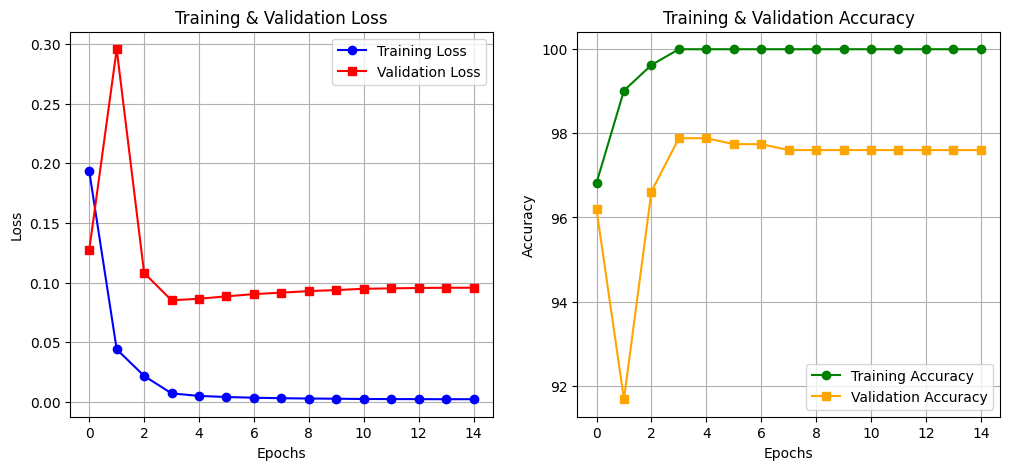

In [117]:
plotting21=plotting(history3)


Evaluating model with Validation loader...

Overall Accuracy: 97.60%
Overall Error Rate: 2.40%
F1-Score (Macro-Averaged): 97.56%
F1-Score (Weighted): 97.61%
Matthews Correlation Coefficient (MCC): 97.20%
Cohen’s Kappa Score: 97.20%
Top-1 Accuracy (%): 97.60%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.074441 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          98.17       96.40         97.27            99.67
 BRRI_28          97.78       97.78         97.78            99.68
 BRRI_29          96.40       96.40         96.40            99.33
 BRRI_34          98.13       98.13         98.13            99.67
 BRRI_50          94.12       97.56         95.81            99.20
 BRRI_74         100.00      100.00        100.00           100.00
    BR_5          98.00       97.03         97.51            99.67

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                111
 B

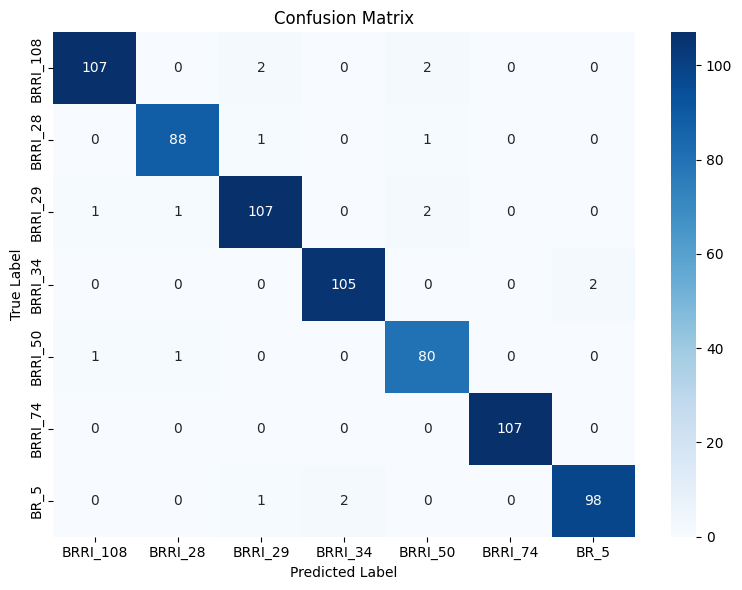

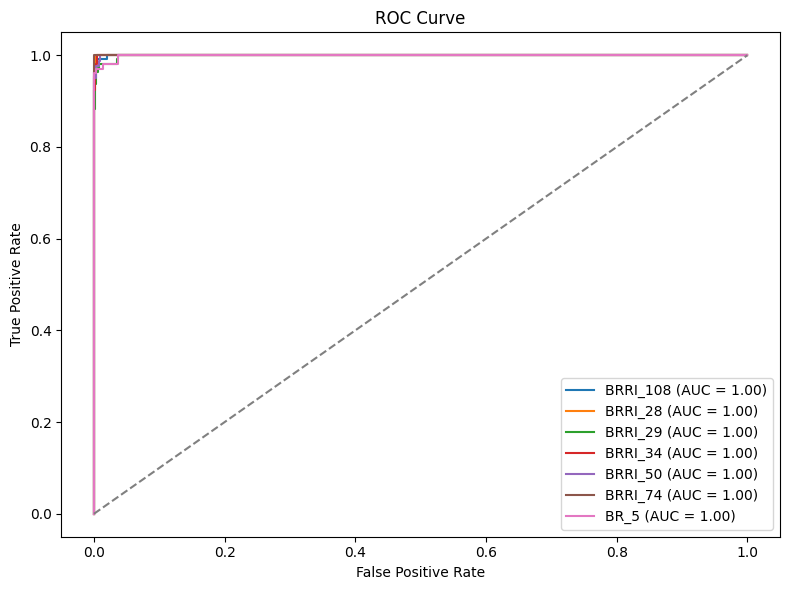

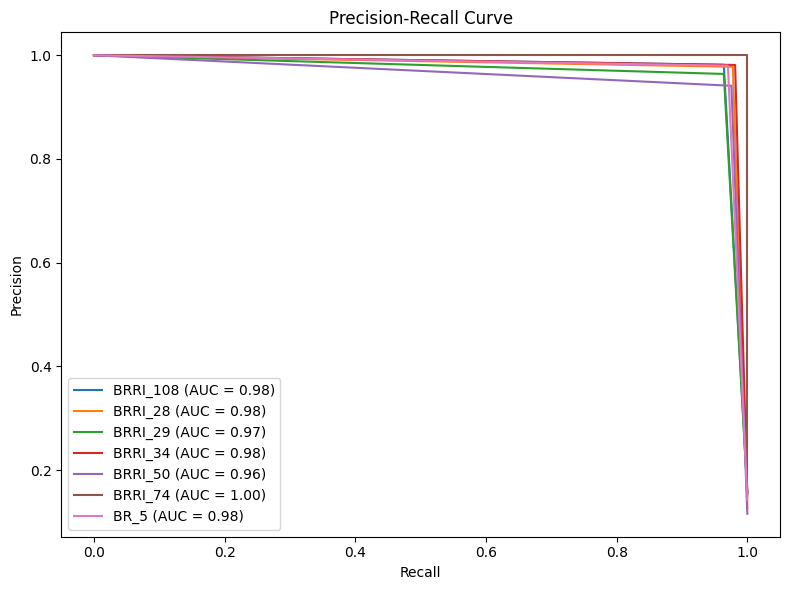

In [118]:
metrics3=evaluate_model(model21, val_loader, class_names=dataset.classes, loader_name="Validation")


Evaluating model with Testing loader...

Overall Accuracy: 96.84%
Overall Error Rate: 3.16%
F1-Score (Macro-Averaged): 96.88%
F1-Score (Weighted): 96.86%
Matthews Correlation Coefficient (MCC): 96.32%
Cohen’s Kappa Score: 96.31%
Top-1 Accuracy (%): 96.84%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.071226 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          95.61       93.16         94.37            99.18
 BRRI_28          96.69       97.50         97.10            99.34
 BRRI_29          90.72       95.65         93.12            98.59
 BRRI_34          97.30       99.08         98.18            99.52
 BRRI_50          99.06       97.22         98.13            99.84
 BRRI_74          98.90       98.90         98.90            99.84
    BR_5         100.00       96.74         98.34           100.00

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                117
 BRRI

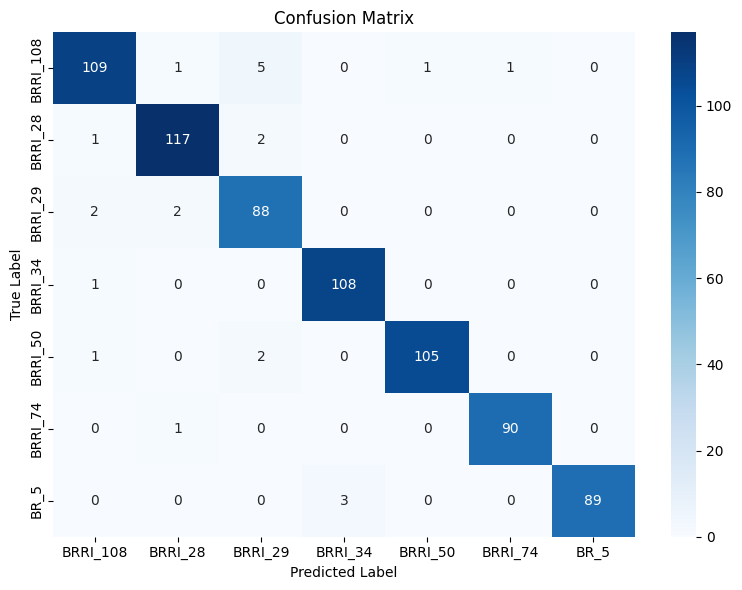

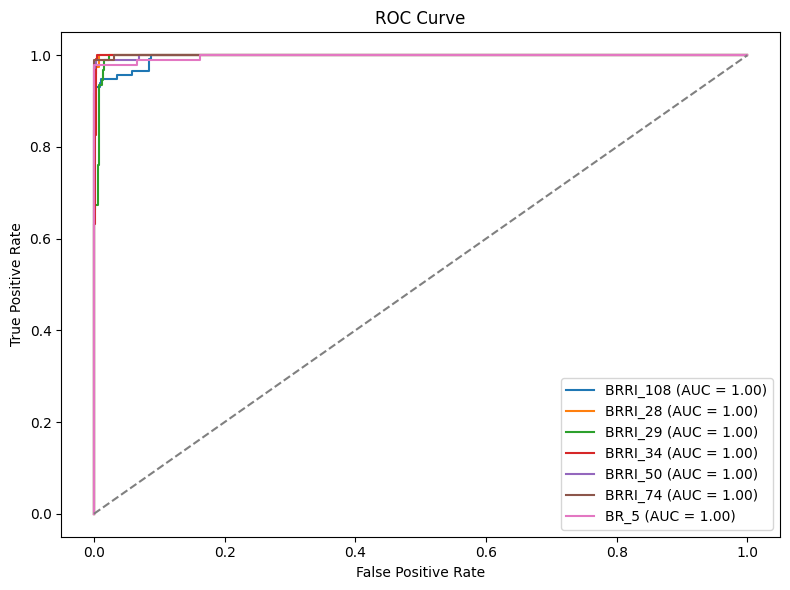

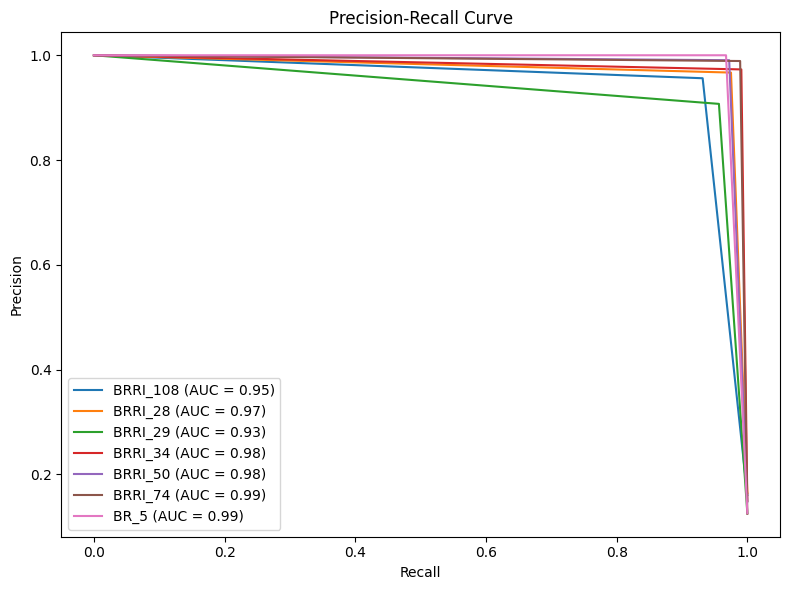

In [119]:
metrics3=evaluate_model(model21, test_loader, class_names=dataset.classes, loader_name="Testing")

In [120]:
def save_deit_artifacts(model, history, metrics, version="V1", base_dir="/Users/tahfimibnkhan/Desktop/ViT_Final"):
    logs_dir = os.path.join(base_dir, "RESULTS", "logs")
    os.makedirs(logs_dir, exist_ok=True)

    training_metrics = {
        "train_loss": history["train_loss"][-1],
        "train_acc": history["train_acc"][-1],
        "val_loss": history["val_loss"][-1],
        "val_acc": history["val_acc"][-1]
    }

    training_metrics_path = os.path.join(logs_dir, f"deit_small_training_metrics_{version}.json")
    with open(training_metrics_path, "w") as f:
        json.dump(training_metrics, f, indent=4)
    print(f"Training metrics logged to {training_metrics_path}")

    model_dir = os.path.join(base_dir, "MODELS", "deit_small")
    os.makedirs(model_dir, exist_ok=True)
    model.to("cpu")
    model_path = os.path.join(model_dir, f"deit_small_{version}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    eval_dir = os.path.join(base_dir, "RESULTS", "evaluation_logs")
    os.makedirs(eval_dir, exist_ok=True)

    eval_metrics_path = os.path.join(eval_dir, f"deit_evaluation_metrics_{version}.json")
    with open(eval_metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)
    print(f"Evaluation metrics saved at: {eval_metrics_path}")

    class_metrics = metrics.get("Class-Wise Metrics") or metrics.get("class_metrics")
    if class_metrics:
        class_metrics_df = pd.DataFrame(class_metrics)
        class_metrics_path = os.path.join(eval_dir, f"deit_class_wise_metrics_{version}.csv")
        class_metrics_df.to_csv(class_metrics_path, index=False)
        print(f"Class-wise metrics saved at: {class_metrics_path}")
    else:
        print("No class-wise metrics found in evaluation results.")
        
save_deit_artifacts(model=model2, history=history2, metrics=metrics2, version="2")

Training metrics logged to /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/logs/deit_small_training_metrics_2.json
Model saved to /Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/deit_small/deit_small_2.pth
Evaluation metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/deit_evaluation_metrics_2.json
Class-wise metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/deit_class_wise_metrics_2.csv


# Version 3

In [140]:
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of output classes
num_classes = 7

# Initialize DeiT model (weights will be loaded next)
model3 = timm.create_model("deit_small_patch16_224", pretrained=False, num_classes=num_classes)

# Modify classification head with dropout
in_features = model3.head.in_features
model3.head = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(512, num_classes)
)

# Load the previous best model (excluding head if needed)
saved_model_path = "/Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/deit_small/deit_small_2.pth"
state_dict = torch.load(saved_model_path, map_location=device)

# If the checkpoint is just a state_dict
if isinstance(state_dict, dict) and 'model_state_dict' in state_dict:
    model3.load_state_dict(state_dict['model_state_dict'], strict=False)
else:
    state_dict = {k: v for k, v in state_dict.items() if "head" not in k}
    model3.load_state_dict(state_dict, strict=False)

model3.to(device)

# Unfreeze all layers
for param in model3.parameters():
    param.requires_grad = True

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer with layer-wise learning rates
optimizer = optim.AdamW([
    {'params': model3.patch_embed.parameters(), 'lr': 1e-5},
    {'params': model3.blocks.parameters(), 'lr': 3e-5},
    {'params': model3.head.parameters(), 'lr': 5e-5}
], weight_decay=5e-5)

# Cosine annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

# Training function
def train_model3(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=15, patience=8):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val_loss = float("inf")
    early_stop_counter = 0

    print("All layers are unfrozen and training resumes...")

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss
            }, "deit_smallV3_best.pth")
            print("Validation improved. Model saved.")
        else:
            early_stop_counter += 1
            print(f"No improvement ({early_stop_counter}/{patience})")
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

    return history

# Changed the sceduler to cosanneling and removed gradual unfreezing, un frooze all the layers at the start.And we have considered this training. Though we have trained another 30. atthe end for better understanding.

In [141]:
extra_epochs = 15 
patience = 15      

# Call the function
history3 = train_model3(
    model=model3,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=extra_epochs,
    patience=patience
)

All layers are unfrozen and training resumes...


Epoch 1/15: 100%|█████████████████████████████| 109/109 [14:49<00:00,  8.16s/it]


Epoch 1/15: Train Loss: 0.3724 | Val Loss: 0.1857 | Train Acc: 93.01% | Val Acc: 93.94%
Validation improved. Model saved.


Epoch 2/15: 100%|█████████████████████████████| 109/109 [16:11<00:00,  8.91s/it]


Epoch 2/15: Train Loss: 0.0694 | Val Loss: 0.2620 | Train Acc: 98.67% | Val Acc: 92.81%
No improvement (1/15)


Epoch 3/15: 100%|█████████████████████████████| 109/109 [15:09<00:00,  8.34s/it]


Epoch 3/15: Train Loss: 0.0287 | Val Loss: 0.1375 | Train Acc: 99.48% | Val Acc: 96.05%
Validation improved. Model saved.


Epoch 4/15: 100%|█████████████████████████████| 109/109 [16:26<00:00,  9.05s/it]


Epoch 4/15: Train Loss: 0.0238 | Val Loss: 0.2222 | Train Acc: 99.48% | Val Acc: 92.38%
No improvement (1/15)


Epoch 5/15: 100%|█████████████████████████████| 109/109 [15:47<00:00,  8.69s/it]


Epoch 5/15: Train Loss: 0.0178 | Val Loss: 0.1550 | Train Acc: 99.54% | Val Acc: 96.47%
No improvement (2/15)


Epoch 6/15: 100%|█████████████████████████████| 109/109 [14:10<00:00,  7.80s/it]


Epoch 6/15: Train Loss: 0.0108 | Val Loss: 0.1153 | Train Acc: 99.86% | Val Acc: 96.90%
Validation improved. Model saved.


Epoch 7/15: 100%|█████████████████████████████| 109/109 [10:09<00:00,  5.59s/it]


Epoch 7/15: Train Loss: 0.0035 | Val Loss: 0.1136 | Train Acc: 100.00% | Val Acc: 97.74%
Validation improved. Model saved.


Epoch 8/15: 100%|█████████████████████████████| 109/109 [09:10<00:00,  5.05s/it]


Epoch 8/15: Train Loss: 0.0026 | Val Loss: 0.1122 | Train Acc: 100.00% | Val Acc: 97.74%
Validation improved. Model saved.


Epoch 9/15: 100%|█████████████████████████████| 109/109 [09:21<00:00,  5.15s/it]


Epoch 9/15: Train Loss: 0.0021 | Val Loss: 0.1136 | Train Acc: 100.00% | Val Acc: 97.74%
No improvement (1/15)


Epoch 10/15: 100%|████████████████████████████| 109/109 [11:07<00:00,  6.12s/it]


Epoch 10/15: Train Loss: 0.0019 | Val Loss: 0.1142 | Train Acc: 100.00% | Val Acc: 97.74%
No improvement (2/15)


Epoch 11/15: 100%|████████████████████████████| 109/109 [11:14<00:00,  6.19s/it]


Epoch 11/15: Train Loss: 0.0018 | Val Loss: 0.1147 | Train Acc: 100.00% | Val Acc: 97.74%
No improvement (3/15)


Epoch 12/15: 100%|████████████████████████████| 109/109 [11:32<00:00,  6.35s/it]


Epoch 12/15: Train Loss: 0.0016 | Val Loss: 0.1151 | Train Acc: 100.00% | Val Acc: 97.74%
No improvement (4/15)


Epoch 13/15: 100%|████████████████████████████| 109/109 [11:52<00:00,  6.54s/it]


Epoch 13/15: Train Loss: 0.0017 | Val Loss: 0.1155 | Train Acc: 100.00% | Val Acc: 97.74%
No improvement (5/15)


Epoch 14/15: 100%|████████████████████████████| 109/109 [09:45<00:00,  5.37s/it]


Epoch 14/15: Train Loss: 0.0015 | Val Loss: 0.1157 | Train Acc: 100.00% | Val Acc: 97.74%
No improvement (6/15)


Epoch 15/15: 100%|████████████████████████████| 109/109 [08:22<00:00,  4.61s/it]


Epoch 15/15: Train Loss: 0.0016 | Val Loss: 0.1157 | Train Acc: 100.00% | Val Acc: 97.74%
No improvement (7/15)



Evaluating model with Validation loader...

Overall Accuracy: 97.74%
Overall Error Rate: 2.26%
F1-Score (Macro-Averaged): 97.79%
F1-Score (Weighted): 97.75%
Matthews Correlation Coefficient (MCC): 97.37%
Cohen’s Kappa Score: 97.36%
Top-1 Accuracy (%): 97.74%
Top-5 Accuracy (%): 99.86%

Average Inference Time per Image: 0.040975 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          92.24       96.40         94.27            98.49
 BRRI_28          98.90      100.00         99.45            99.84
 BRRI_29          98.15       95.50         96.80            99.67
 BRRI_34         100.00       98.13         99.06           100.00
 BRRI_50          97.53       96.34         96.93            99.68
 BRRI_74         100.00      100.00        100.00           100.00
    BR_5          98.02       98.02         98.02            99.67

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                111
 BR

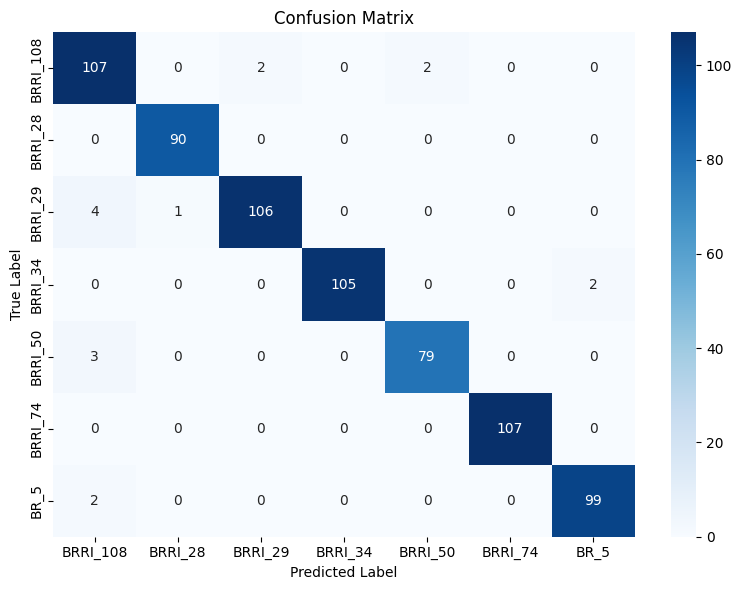

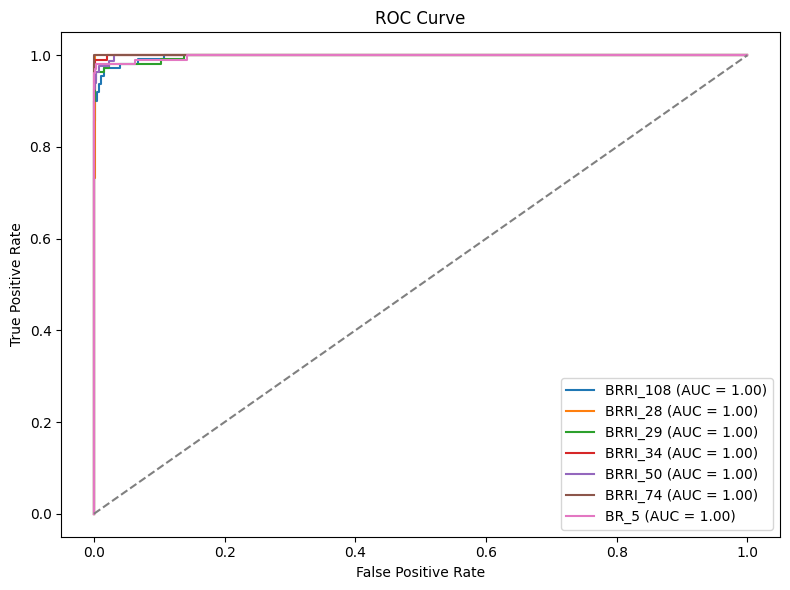

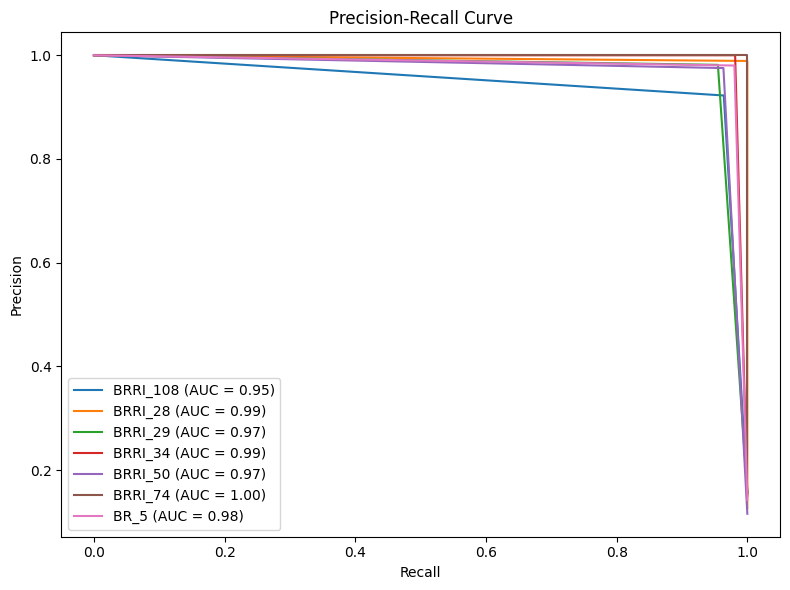

In [142]:
metrics3=evaluate_model(model3, val_loader, class_names=dataset.classes, loader_name="Validation")


Evaluating model with Testing loader...

Overall Accuracy: 96.57%
Overall Error Rate: 3.43%
F1-Score (Macro-Averaged): 96.60%
F1-Score (Weighted): 96.59%
Matthews Correlation Coefficient (MCC): 96.01%
Cohen’s Kappa Score: 95.99%
Top-1 Accuracy (%): 96.57%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.044778 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          95.58       92.31         93.91            99.18
 BRRI_28          99.14       95.83         97.46            99.84
 BRRI_29          89.11       97.83         93.26            98.27
 BRRI_34          95.58       99.08         97.30            99.19
 BRRI_50          99.06       97.22         98.13            99.84
 BRRI_74          98.90       98.90         98.90            99.84
    BR_5          98.88       95.65         97.24            99.84

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                117
 BRRI

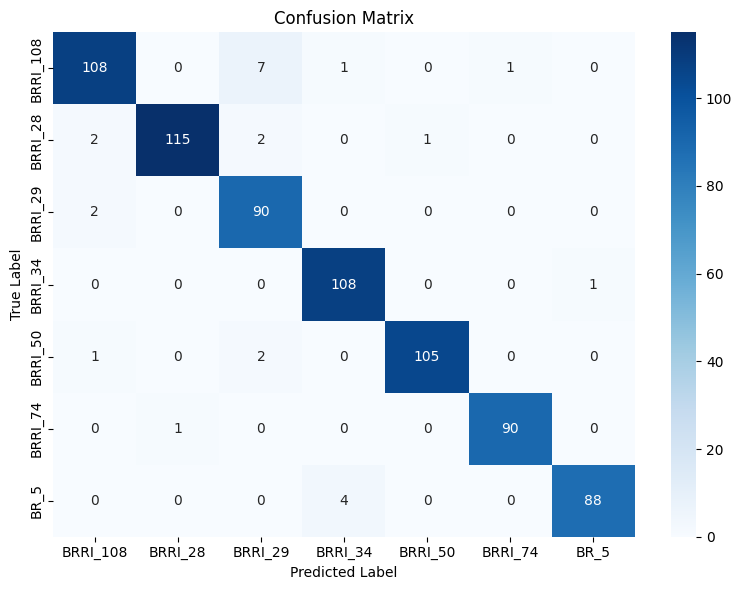

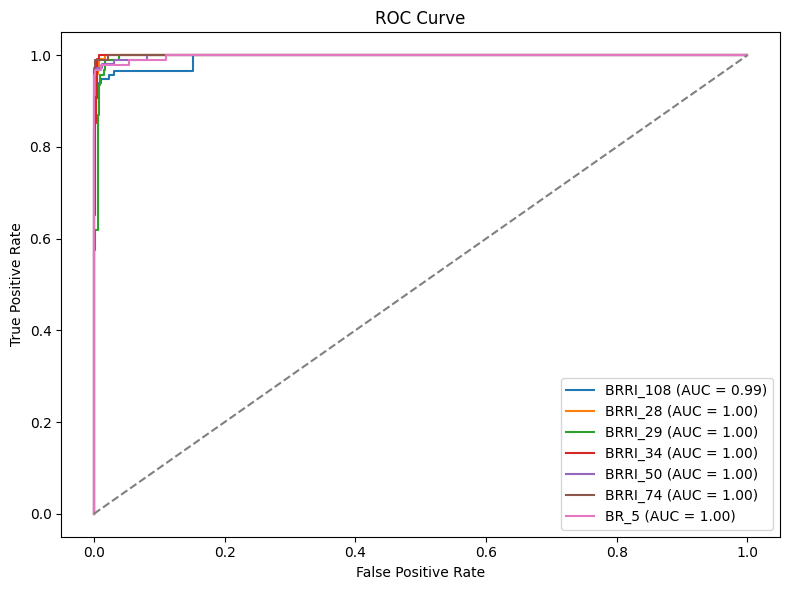

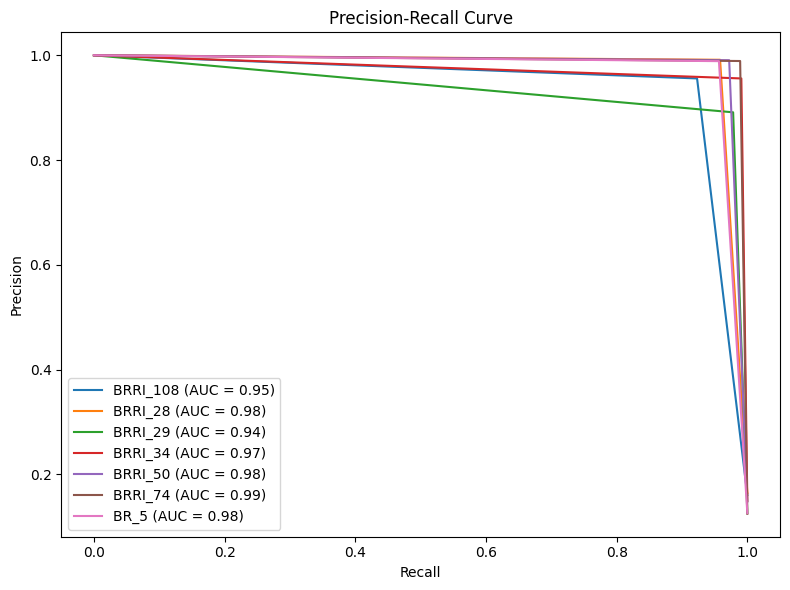

In [143]:
metrics3=evaluate_model(model3, test_loader, class_names=dataset.classes, loader_name="Testing")

# This was trained with gradual unfreezing earlier. But we are not taking it, I removed gradual unfreezing, As it was decreasing the overall accuracy.

In [121]:
# Training is initiated
history3 = train_model3(
    model3=model3,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    extra_epochs=15,
    patience=12
)

Epoch 1/15: 100%|█████████████████████████████| 109/109 [11:25<00:00,  6.29s/it]


Epoch 1/15: Train Loss: 0.2929 | Val Loss: 0.1108 | Train Acc: 95.61% | Val Acc: 96.61%
The model has improved and been saved.


Epoch 2/15: 100%|█████████████████████████████| 109/109 [10:24<00:00,  5.73s/it]


Epoch 2/15: Train Loss: 0.0373 | Val Loss: 0.2444 | Train Acc: 99.42% | Val Acc: 93.51%
No improvement observed (1/12)


Epoch 3/15: 100%|█████████████████████████████| 109/109 [11:48<00:00,  6.50s/it]


Epoch 3/15: Train Loss: 0.0268 | Val Loss: 0.0851 | Train Acc: 99.39% | Val Acc: 97.32%
The model has improved and been saved.
The third transformer block is unfrozen.


Epoch 4/15: 100%|█████████████████████████████| 109/109 [10:03<00:00,  5.54s/it]


Epoch 4/15: Train Loss: 0.0077 | Val Loss: 0.0889 | Train Acc: 99.91% | Val Acc: 97.18%
No improvement observed (1/12)


Epoch 5/15: 100%|█████████████████████████████| 109/109 [09:49<00:00,  5.41s/it]


Epoch 5/15: Train Loss: 0.0035 | Val Loss: 0.0916 | Train Acc: 100.00% | Val Acc: 97.18%
No improvement observed (2/12)


Epoch 6/15: 100%|█████████████████████████████| 109/109 [09:31<00:00,  5.24s/it]


Epoch 6/15: Train Loss: 0.0025 | Val Loss: 0.0939 | Train Acc: 100.00% | Val Acc: 97.18%
No improvement observed (3/12)
The second transformer block is unfrozen.


Epoch 7/15: 100%|█████████████████████████████| 109/109 [09:50<00:00,  5.42s/it]


Epoch 7/15: Train Loss: 0.0131 | Val Loss: 0.4110 | Train Acc: 99.80% | Val Acc: 88.29%
No improvement observed (4/12)


Epoch 8/15: 100%|█████████████████████████████| 109/109 [10:06<00:00,  5.57s/it]


Epoch 8/15: Train Loss: 0.1176 | Val Loss: 0.2250 | Train Acc: 96.88% | Val Acc: 92.24%
No improvement observed (5/12)


Epoch 9/15: 100%|█████████████████████████████| 109/109 [10:04<00:00,  5.55s/it]


Epoch 9/15: Train Loss: 0.0108 | Val Loss: 0.1009 | Train Acc: 99.80% | Val Acc: 96.61%
No improvement observed (6/12)
The first transformer block is unfrozen.


Epoch 10/15: 100%|████████████████████████████| 109/109 [11:16<00:00,  6.20s/it]


Epoch 10/15: Train Loss: 0.0048 | Val Loss: 0.0888 | Train Acc: 100.00% | Val Acc: 97.04%
No improvement observed (7/12)


Epoch 11/15: 100%|████████████████████████████| 109/109 [50:08<00:00, 27.60s/it]


Epoch 11/15: Train Loss: 0.0037 | Val Loss: 0.0880 | Train Acc: 100.00% | Val Acc: 96.90%
No improvement observed (8/12)


Epoch 12/15: 100%|████████████████████████████| 109/109 [08:39<00:00,  4.76s/it]


Epoch 12/15: Train Loss: 0.0033 | Val Loss: 0.0872 | Train Acc: 100.00% | Val Acc: 97.18%
No improvement observed (9/12)


Epoch 13/15: 100%|████████████████████████████| 109/109 [09:24<00:00,  5.18s/it]


Epoch 13/15: Train Loss: 0.0030 | Val Loss: 0.0862 | Train Acc: 100.00% | Val Acc: 97.18%
No improvement observed (10/12)


Epoch 14/15: 100%|████████████████████████████| 109/109 [09:37<00:00,  5.30s/it]


Epoch 14/15: Train Loss: 0.0028 | Val Loss: 0.0862 | Train Acc: 100.00% | Val Acc: 97.18%
No improvement observed (11/12)


Epoch 15/15: 100%|████████████████████████████| 109/109 [10:20<00:00,  5.70s/it]


Epoch 15/15: Train Loss: 0.0028 | Val Loss: 0.0862 | Train Acc: 100.00% | Val Acc: 97.18%
No improvement observed (12/12)
Early stopping is triggered.


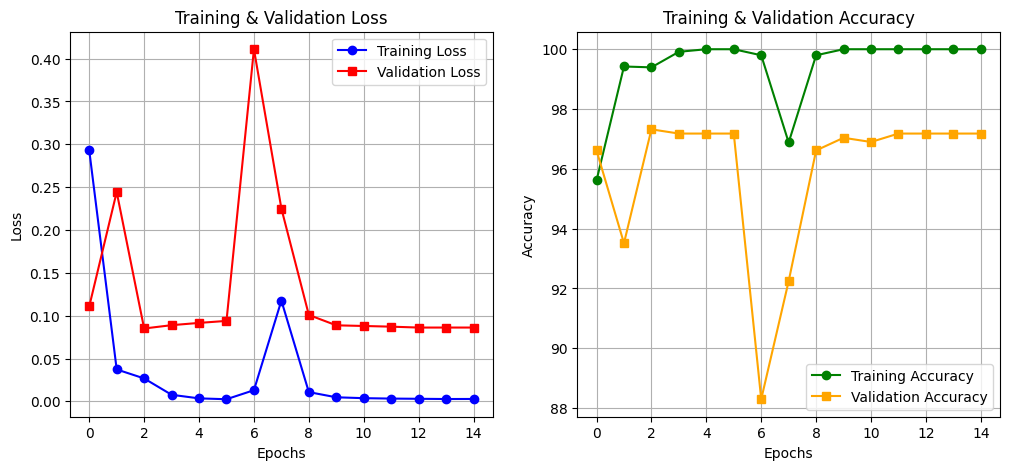

In [122]:
# The traing and validation graph is plotted
plottting3=plotting(history3)


Evaluating model with Validation loader...

Overall Accuracy: 97.18%
Overall Error Rate: 2.82%
F1-Score (Macro-Averaged): 97.23%
F1-Score (Weighted): 97.17%
Matthews Correlation Coefficient (MCC): 96.70%
Cohen’s Kappa Score: 96.70%
Top-1 Accuracy (%): 97.18%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.026144 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          96.40       96.40         96.40            99.33
 BRRI_28          97.73       95.56         96.63            99.68
 BRRI_29          94.55       93.69         94.12            99.00
 BRRI_34          98.13       98.13         98.13            99.67
 BRRI_50          97.62      100.00         98.80            99.68
 BRRI_74          99.07      100.00         99.53            99.83
    BR_5          97.03       97.03         97.03            99.51

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                111
 B

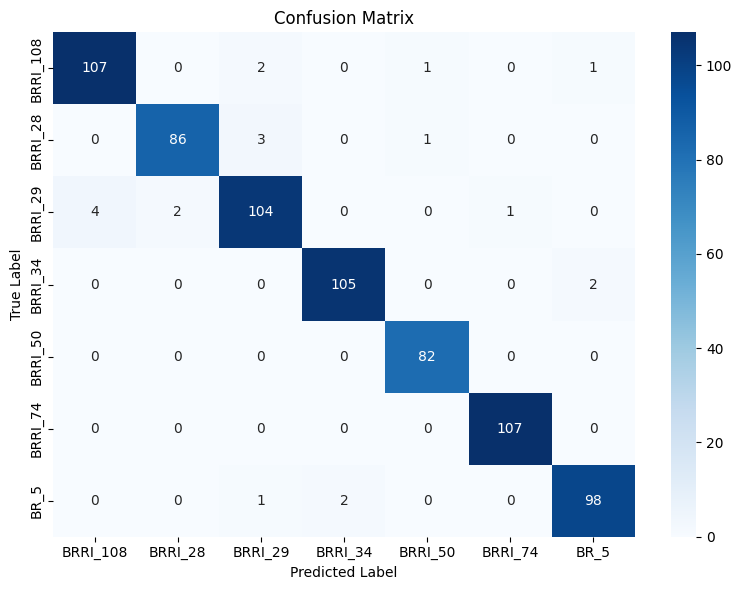

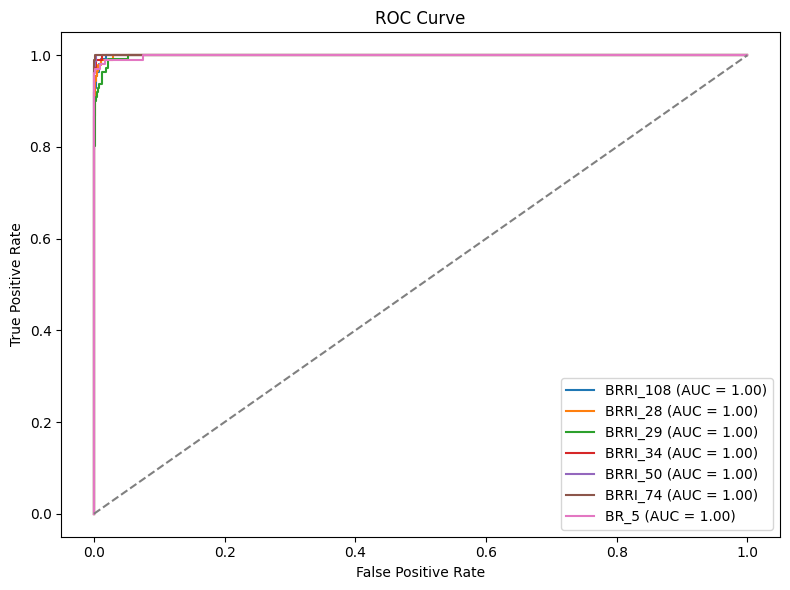

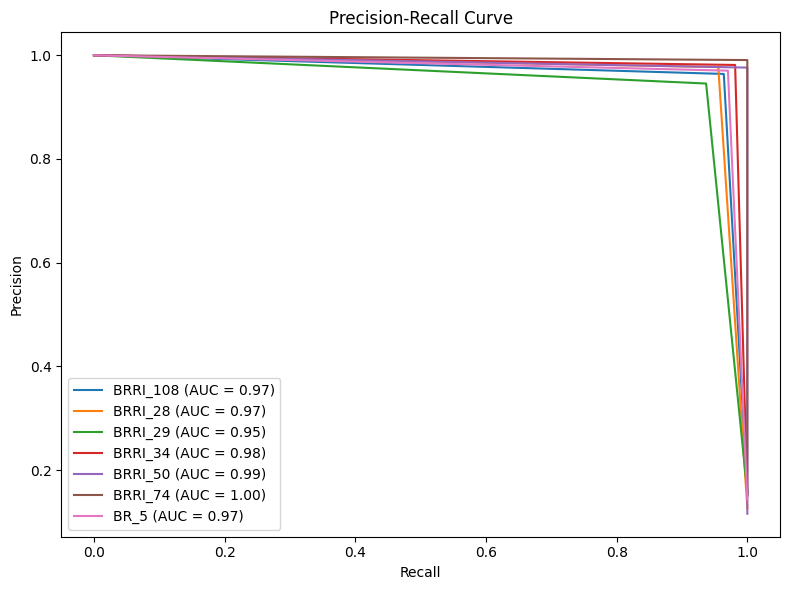

In [123]:
metrics3=evaluate_model(model3, val_loader, class_names=dataset.classes, loader_name="Validation")


Evaluating model with Testing loader...

Overall Accuracy: 97.12%
Overall Error Rate: 2.88%
F1-Score (Macro-Averaged): 97.12%
F1-Score (Weighted): 97.13%
Matthews Correlation Coefficient (MCC): 96.63%
Cohen’s Kappa Score: 96.63%
Top-1 Accuracy (%): 97.12%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.028106 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          96.52       94.87         95.69            99.35
 BRRI_28          96.69       97.50         97.10            99.34
 BRRI_29          91.49       93.48         92.47            98.74
 BRRI_34          98.17       98.17         98.17            99.68
 BRRI_50          98.17       99.07         98.62            99.68
 BRRI_74         100.00       98.90         99.45           100.00
    BR_5          98.90       97.83         98.36            99.84

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                117
 BRRI

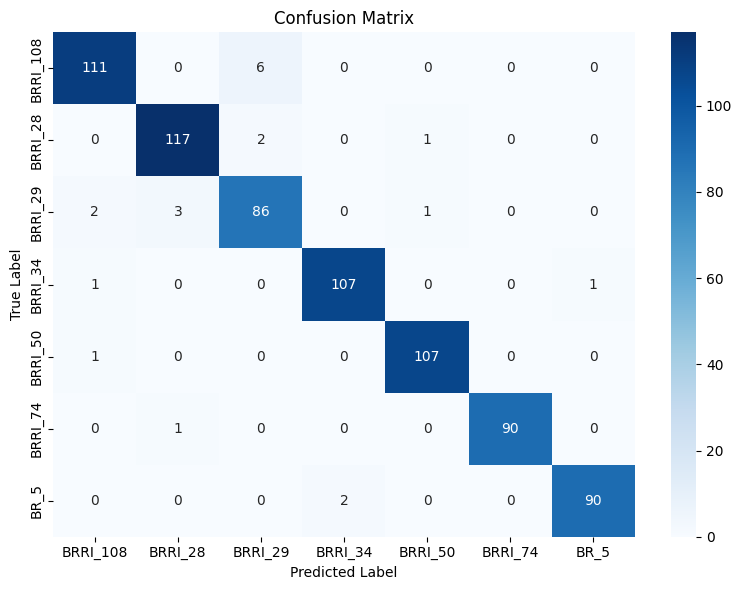

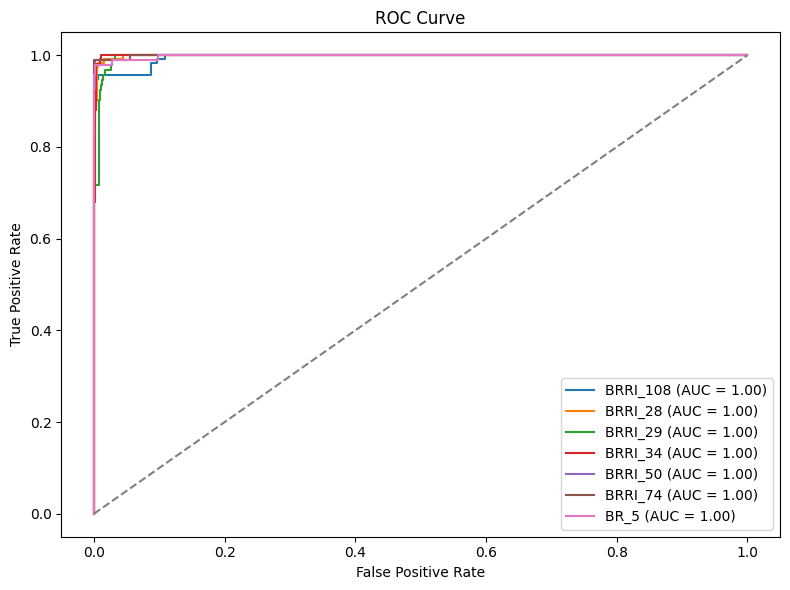

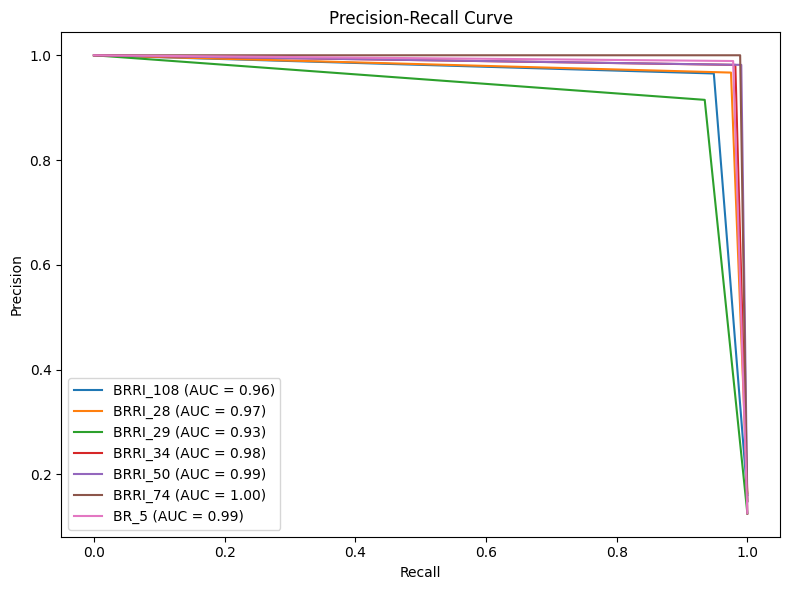

In [125]:
metrics3=evaluate_model(model3, test_loader, class_names=dataset.classes, loader_name="Testing")

In [146]:
def save_deit_artifacts(model, history, metrics, version="V1", base_dir="/Users/tahfimibnkhan/Desktop/ViT_Final"):
    logs_dir = os.path.join(base_dir, "RESULTS", "logs")
    os.makedirs(logs_dir, exist_ok=True)

    training_metrics = {
        "train_loss": history["train_loss"][-1],
        "train_acc": history["train_acc"][-1],
        "val_loss": history["val_loss"][-1],
        "val_acc": history["val_acc"][-1]
    }

    training_metrics_path = os.path.join(logs_dir, f"deit_small_training_metrics_{version}.json")
    with open(training_metrics_path, "w") as f:
        json.dump(training_metrics, f, indent=4)
    print(f"Training metrics logged to {training_metrics_path}")

    model_dir = os.path.join(base_dir, "MODELS", "deit_small")
    os.makedirs(model_dir, exist_ok=True)
    model.to("cpu")
    model_path = os.path.join(model_dir, f"deit_small_{version}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    eval_dir = os.path.join(base_dir, "RESULTS", "evaluation_logs")
    os.makedirs(eval_dir, exist_ok=True)

    eval_metrics_path = os.path.join(eval_dir, f"deit_evaluation_metrics_{version}.json")
    with open(eval_metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)
    print(f"Evaluation metrics saved at: {eval_metrics_path}")

    class_metrics = metrics.get("Class-Wise Metrics") or metrics.get("class_metrics")
    if class_metrics:
        class_metrics_df = pd.DataFrame(class_metrics)
        class_metrics_path = os.path.join(eval_dir, f"deit_class_wise_metrics_{version}.csv")
        class_metrics_df.to_csv(class_metrics_path, index=False)
        print(f"Class-wise metrics saved at: {class_metrics_path}")
    else:
        print("No class-wise metrics found in evaluation results.")
        
save_deit_artifacts(model=model3, history=history3, metrics=metrics3, version="3")

Training metrics logged to /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/logs/deit_small_training_metrics_3.json
Model saved to /Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/deit_small/deit_small_3.pth
Evaluation metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/deit_evaluation_metrics_3.json
Class-wise metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/deit_class_wise_metrics_3.csv


In [126]:
def merge_histories(history1, history2):
    merged = {}
    for key in history1:
        merged[key] = history1[key] + history2.get(key, [])
    return merged
full_history = merge_histories(history1, history3)

# Adding 30 epochs instead of 15 to see if the situation improves.

In [149]:
extra_epochs = 30
patience = 30      

# Call the function
history3 = train_model3(
    model=model3,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=extra_epochs,
    patience=patience
)

All layers are unfrozen and training resumes...


Epoch 1/30: 100%|█████████████████████████████| 109/109 [11:58<00:00,  6.59s/it]


Epoch 1/30: Train Loss: 0.0015 | Val Loss: 0.1157 | Train Acc: 100.00% | Val Acc: 97.74%
Validation improved. Model saved.


Epoch 2/30: 100%|█████████████████████████████| 109/109 [11:47<00:00,  6.49s/it]


Epoch 2/30: Train Loss: 0.0015 | Val Loss: 0.1157 | Train Acc: 100.00% | Val Acc: 97.74%
No improvement (1/30)


Epoch 3/30: 100%|█████████████████████████████| 109/109 [13:25<00:00,  7.39s/it]


Epoch 3/30: Train Loss: 0.0015 | Val Loss: 0.1159 | Train Acc: 100.00% | Val Acc: 97.74%
No improvement (2/30)


Epoch 4/30: 100%|█████████████████████████████| 109/109 [13:55<00:00,  7.67s/it]


Epoch 4/30: Train Loss: 0.0015 | Val Loss: 0.1163 | Train Acc: 100.00% | Val Acc: 97.74%
No improvement (3/30)


Epoch 5/30: 100%|█████████████████████████████| 109/109 [13:28<00:00,  7.42s/it]


Epoch 5/30: Train Loss: 0.0014 | Val Loss: 0.1174 | Train Acc: 100.00% | Val Acc: 97.74%
No improvement (4/30)


Epoch 6/30: 100%|█████████████████████████████| 109/109 [14:38<00:00,  8.06s/it]


Epoch 6/30: Train Loss: 0.0013 | Val Loss: 0.1182 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement (5/30)


Epoch 7/30: 100%|█████████████████████████████| 109/109 [13:20<00:00,  7.35s/it]


Epoch 7/30: Train Loss: 0.0012 | Val Loss: 0.1200 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement (6/30)


Epoch 8/30: 100%|█████████████████████████████| 109/109 [13:52<00:00,  7.64s/it]


Epoch 8/30: Train Loss: 0.0010 | Val Loss: 0.1219 | Train Acc: 100.00% | Val Acc: 97.74%
No improvement (7/30)


Epoch 9/30: 100%|█████████████████████████████| 109/109 [16:02<00:00,  8.83s/it]


Epoch 9/30: Train Loss: 0.0009 | Val Loss: 0.1241 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement (8/30)


Epoch 10/30: 100%|████████████████████████████| 109/109 [14:03<00:00,  7.73s/it]


Epoch 10/30: Train Loss: 0.0007 | Val Loss: 0.1252 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement (9/30)


Epoch 11/30: 100%|████████████████████████████| 109/109 [16:03<00:00,  8.84s/it]


Epoch 11/30: Train Loss: 0.0006 | Val Loss: 0.1274 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement (10/30)


Epoch 12/30: 100%|████████████████████████████| 109/109 [13:36<00:00,  7.49s/it]


Epoch 12/30: Train Loss: 0.0005 | Val Loss: 0.1294 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement (11/30)


Epoch 13/30: 100%|████████████████████████████| 109/109 [15:12<00:00,  8.37s/it]


Epoch 13/30: Train Loss: 0.0004 | Val Loss: 0.1311 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement (12/30)


Epoch 14/30: 100%|████████████████████████████| 109/109 [14:14<00:00,  7.84s/it]


Epoch 14/30: Train Loss: 0.0003 | Val Loss: 0.1336 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement (13/30)


Epoch 15/30: 100%|████████████████████████████| 109/109 [15:29<00:00,  8.53s/it]


Epoch 15/30: Train Loss: 0.0003 | Val Loss: 0.1353 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement (14/30)


Epoch 16/30: 100%|████████████████████████████| 109/109 [13:49<00:00,  7.61s/it]


Epoch 16/30: Train Loss: 0.0002 | Val Loss: 0.1381 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement (15/30)


Epoch 17/30: 100%|████████████████████████████| 109/109 [15:14<00:00,  8.39s/it]


Epoch 17/30: Train Loss: 0.0002 | Val Loss: 0.1397 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement (16/30)


Epoch 18/30: 100%|████████████████████████████| 109/109 [14:14<00:00,  7.84s/it]


Epoch 18/30: Train Loss: 0.0002 | Val Loss: 0.1403 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement (17/30)


Epoch 19/30: 100%|████████████████████████████| 109/109 [13:55<00:00,  7.67s/it]


Epoch 19/30: Train Loss: 0.0002 | Val Loss: 0.1422 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement (18/30)


Epoch 20/30: 100%|████████████████████████████| 109/109 [14:35<00:00,  8.03s/it]


Epoch 20/30: Train Loss: 0.0002 | Val Loss: 0.1437 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement (19/30)


Epoch 21/30: 100%|████████████████████████████| 109/109 [13:40<00:00,  7.53s/it]


Epoch 21/30: Train Loss: 0.0001 | Val Loss: 0.1444 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement (20/30)


Epoch 22/30: 100%|████████████████████████████| 109/109 [14:48<00:00,  8.15s/it]


Epoch 22/30: Train Loss: 0.0001 | Val Loss: 0.1453 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement (21/30)


Epoch 23/30: 100%|████████████████████████████| 109/109 [13:22<00:00,  7.36s/it]


Epoch 23/30: Train Loss: 0.0001 | Val Loss: 0.1452 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement (22/30)


Epoch 24/30: 100%|████████████████████████████| 109/109 [13:49<00:00,  7.61s/it]


Epoch 24/30: Train Loss: 0.0001 | Val Loss: 0.1458 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement (23/30)


Epoch 25/30: 100%|████████████████████████████| 109/109 [14:12<00:00,  7.82s/it]


Epoch 25/30: Train Loss: 0.0001 | Val Loss: 0.1464 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement (24/30)


Epoch 26/30: 100%|████████████████████████████| 109/109 [13:07<00:00,  7.22s/it]


Epoch 26/30: Train Loss: 0.0001 | Val Loss: 0.1469 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement (25/30)


Epoch 27/30: 100%|████████████████████████████| 109/109 [13:58<00:00,  7.69s/it]


Epoch 27/30: Train Loss: 0.0001 | Val Loss: 0.1471 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement (26/30)


Epoch 28/30: 100%|████████████████████████████| 109/109 [13:50<00:00,  7.62s/it]


Epoch 28/30: Train Loss: 0.0001 | Val Loss: 0.1473 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement (27/30)


Epoch 29/30: 100%|████████████████████████████| 109/109 [14:25<00:00,  7.94s/it]


Epoch 29/30: Train Loss: 0.0001 | Val Loss: 0.1474 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement (28/30)


Epoch 30/30: 100%|████████████████████████████| 109/109 [15:40<00:00,  8.63s/it]


Epoch 30/30: Train Loss: 0.0001 | Val Loss: 0.1474 | Train Acc: 100.00% | Val Acc: 97.60%
No improvement (29/30)


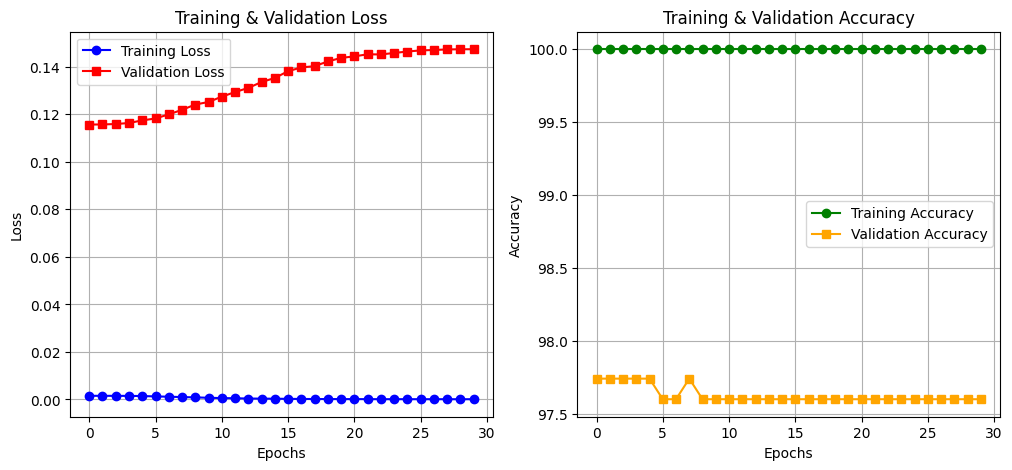

In [150]:
plotting(history3)


Evaluating model with Validation loader...

Overall Accuracy: 97.60%
Overall Error Rate: 2.40%
F1-Score (Macro-Averaged): 97.60%
F1-Score (Weighted): 97.61%
Matthews Correlation Coefficient (MCC): 97.21%
Cohen’s Kappa Score: 97.20%
Top-1 Accuracy (%): 97.60%
Top-5 Accuracy (%): 99.86%

Average Inference Time per Image: 0.095372 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          92.31       97.30         94.74            98.49
 BRRI_28          98.89       98.89         98.89            99.84
 BRRI_29          99.06       94.59         96.77            99.83
 BRRI_34         100.00       98.13         99.06           100.00
 BRRI_50          95.18       96.34         95.76            99.36
 BRRI_74         100.00      100.00        100.00           100.00
    BR_5          98.02       98.02         98.02            99.67

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                111
 BR

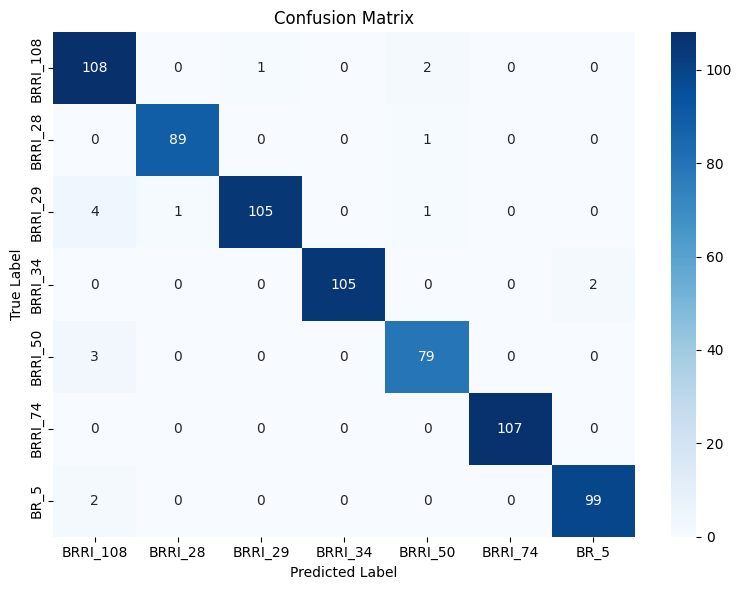

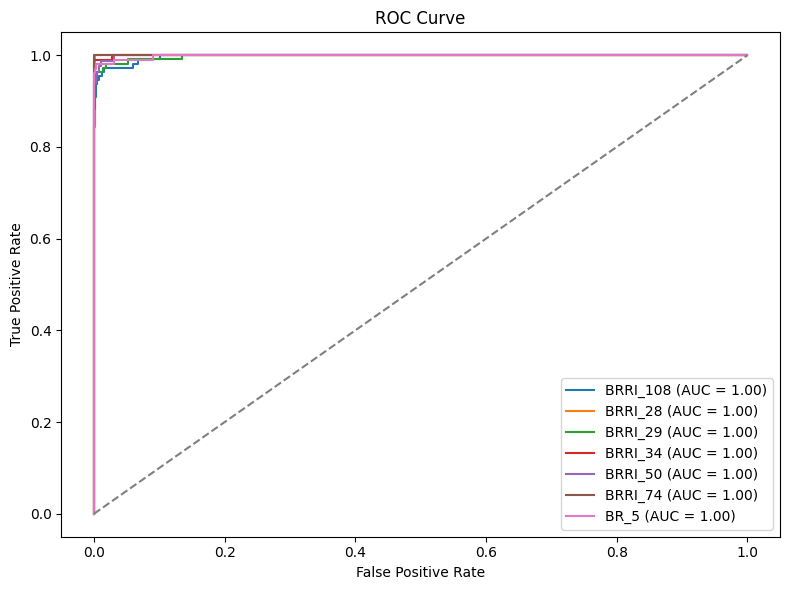

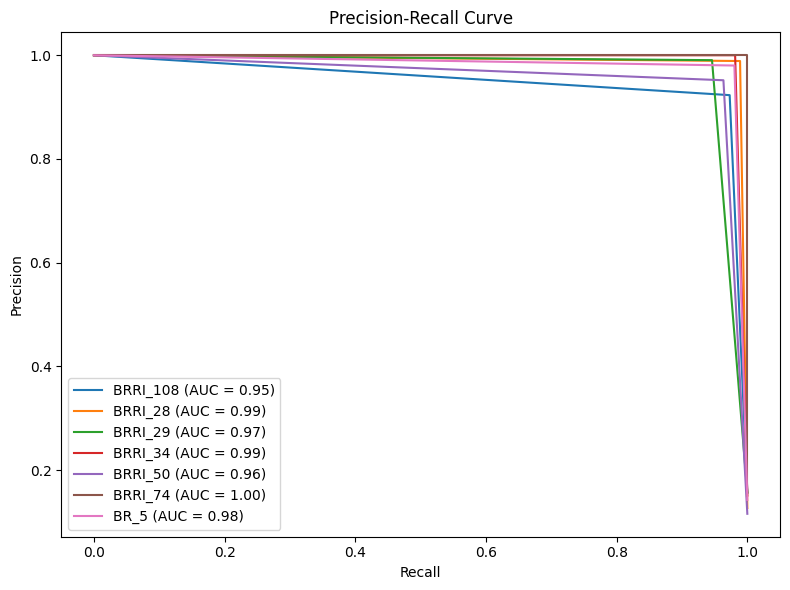

{'accuracy': 97.6,
 'error_rate': 2.4,
 'f1_macro': 97.6,
 'f1_weighted': 97.61,
 'roc_auc': 99.9,
 'mcc': 97.21,
 'kappa': 97.2,
 'top_k_accuracy': {'Top-1 Accuracy (%)': 97.60225669957687,
  'Top-5 Accuracy (%)': 99.8589562764457},
 'avg_inference_time': 0.09537170400740566,
 'class_metrics': [{'Class': 'BRRI_108',
   'Precision (%)': 92.31,
   'Recall (%)': 97.3,
   'F1-Score (%)': 94.74,
   'Specificity (%)': 98.49},
  {'Class': 'BRRI_28',
   'Precision (%)': 98.89,
   'Recall (%)': 98.89,
   'F1-Score (%)': 98.89,
   'Specificity (%)': 99.84},
  {'Class': 'BRRI_29',
   'Precision (%)': 99.06,
   'Recall (%)': 94.59,
   'F1-Score (%)': 96.77,
   'Specificity (%)': 99.83},
  {'Class': 'BRRI_34',
   'Precision (%)': 100.0,
   'Recall (%)': 98.13,
   'F1-Score (%)': 99.06,
   'Specificity (%)': 100.0},
  {'Class': 'BRRI_50',
   'Precision (%)': 95.18,
   'Recall (%)': 96.34,
   'F1-Score (%)': 95.76,
   'Specificity (%)': 99.36},
  {'Class': 'BRRI_74',
   'Precision (%)': 100.0,
   'R

In [151]:
evaluate_model(model3, val_loader, class_names=dataset.classes, loader_name="Validation")


Evaluating model with Testing loader...

Overall Accuracy: 96.84%
Overall Error Rate: 3.16%
F1-Score (Macro-Averaged): 96.86%
F1-Score (Weighted): 96.86%
Matthews Correlation Coefficient (MCC): 96.33%
Cohen’s Kappa Score: 96.31%
Top-1 Accuracy (%): 96.84%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.077482 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          96.43       92.31         94.32            99.35
 BRRI_28          99.15       96.67         97.89            99.84
 BRRI_29          89.11       97.83         93.26            98.27
 BRRI_34          95.61      100.00         97.76            99.19
 BRRI_50          99.06       97.22         98.13            99.84
 BRRI_74          98.90       98.90         98.90            99.84
    BR_5         100.00       95.65         97.78           100.00

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                117
 BRRI

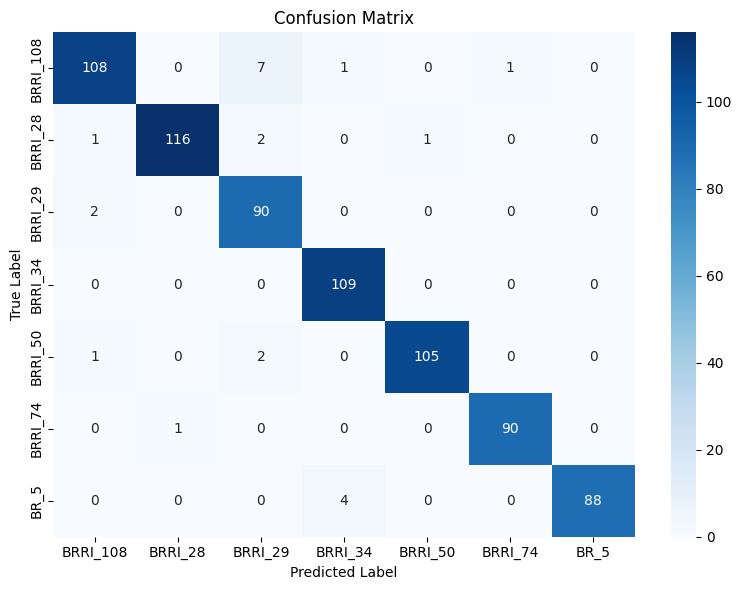

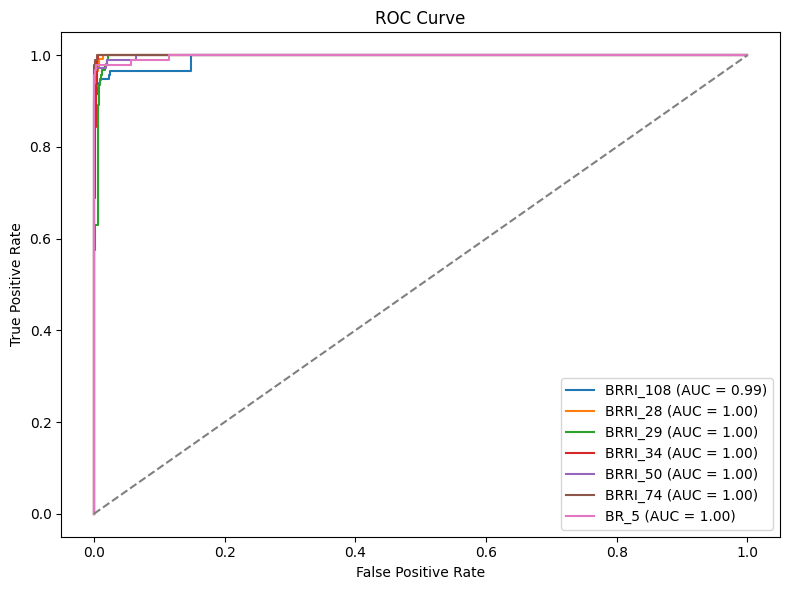

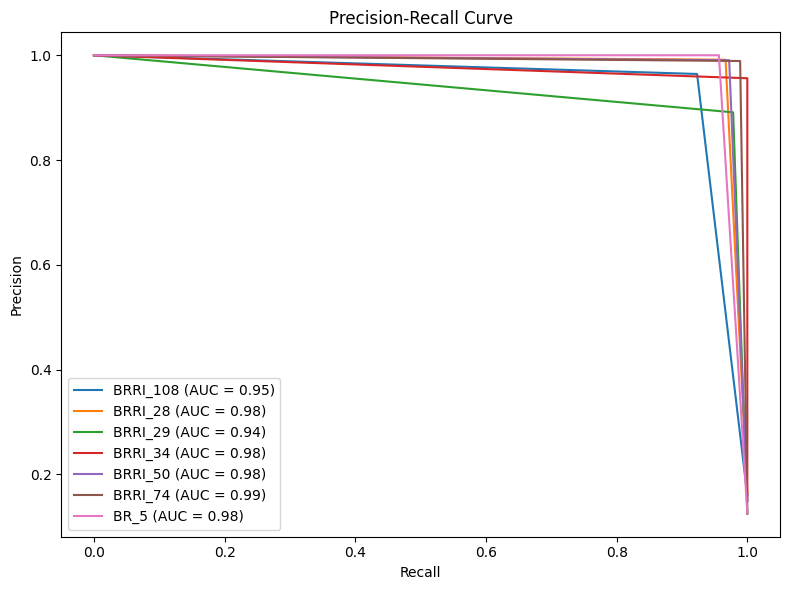

{'accuracy': 96.84,
 'error_rate': 3.16,
 'f1_macro': 96.86,
 'f1_weighted': 96.86,
 'roc_auc': 99.81,
 'mcc': 96.33,
 'kappa': 96.31,
 'top_k_accuracy': {'Top-1 Accuracy (%)': 96.84499314128944,
  'Top-5 Accuracy (%)': 100.0},
 'avg_inference_time': 0.07748177774322049,
 'class_metrics': [{'Class': 'BRRI_108',
   'Precision (%)': 96.43,
   'Recall (%)': 92.31,
   'F1-Score (%)': 94.32,
   'Specificity (%)': 99.35},
  {'Class': 'BRRI_28',
   'Precision (%)': 99.15,
   'Recall (%)': 96.67,
   'F1-Score (%)': 97.89,
   'Specificity (%)': 99.84},
  {'Class': 'BRRI_29',
   'Precision (%)': 89.11,
   'Recall (%)': 97.83,
   'F1-Score (%)': 93.26,
   'Specificity (%)': 98.27},
  {'Class': 'BRRI_34',
   'Precision (%)': 95.61,
   'Recall (%)': 100.0,
   'F1-Score (%)': 97.76,
   'Specificity (%)': 99.19},
  {'Class': 'BRRI_50',
   'Precision (%)': 99.06,
   'Recall (%)': 97.22,
   'F1-Score (%)': 98.13,
   'Specificity (%)': 99.84},
  {'Class': 'BRRI_74',
   'Precision (%)': 98.9,
   'Recall 

In [152]:
evaluate_model(model3, test_loader, class_names=dataset.classes, loader_name="Testing")

Merged 55 epochs of training.


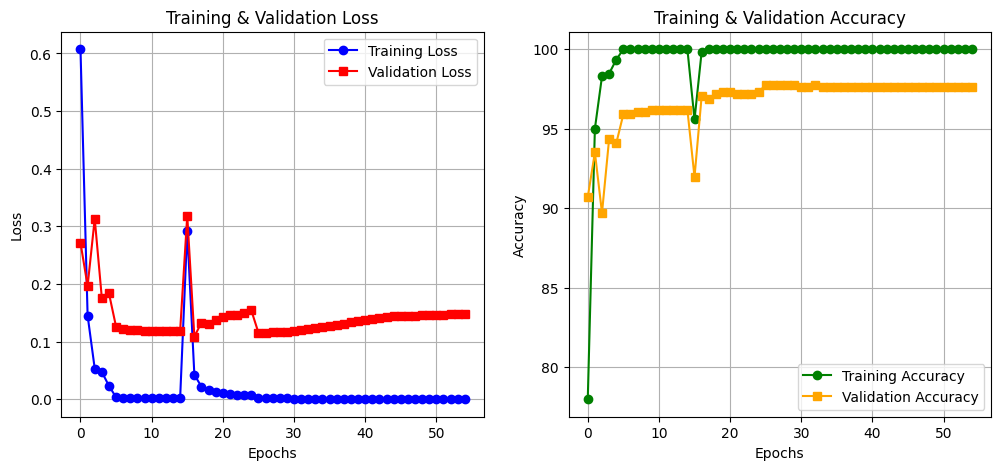

In [155]:
def merge_histories_and_plot(history1, history2, history3):
    """
    Merges three training history dictionaries and plots the combined training and validation curves.

    Args:
        history1, history2, history3: Dictionaries with keys "train_loss", "train_acc", "val_loss", "val_acc"
    """
    merged_history = {
        "train_loss": history1["train_loss"] + history2["train_loss"] + history3["train_loss"],
        "train_acc": history1["train_acc"] + history2["train_acc"] + history3["train_acc"],
        "val_loss": history1["val_loss"] + history2["val_loss"] + history3["val_loss"],
        "val_acc": history1["val_acc"] + history2["val_acc"] + history3["val_acc"]
    }

    print(f"Merged {len(history1['train_loss']) + len(history2['train_loss']) + len(history3['train_loss'])} epochs of training.")
    plotting(merged_history)
    return merged_history

final_history = merge_histories_and_plot(history1, history2, history3)